In [1]:
import copy
import pickle
import multiprocessing

import torch
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader

from util.helpers import *
from util.run import train, validate
from util.sample import sample
from util.dataset import HaydnDataset, ChunksDataset
from util.models import PitchEmbedModel, HarmonyModel, JudgeModel, NoteModel

from music21 import converter

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device("cpu")
    
# number of instrument parts
NUM_PARTS = 4

print("Device: {}".format(device))

RUN_ID = get_unique_id()
RUN_TIME = get_formatted_time()

print("RUN_ID: {}".format(RUN_ID))
print("RUN_TIME: {}".format(RUN_TIME))

Device: cuda
RUN_ID: 4159EF
RUN_TIME: 12-10_04-50-43


In [2]:
# LOAD HAYDN DATASET

SKIP_DATA = False

if not SKIP_DATA:
    haydn_dataset = HaydnDataset()

Building dataset...
Serialized scores found, loading...
Scores loaded in 20.06 seconds.


In [3]:
# SETUP DATA LOADERs

SEQ_LEN = 32
STRIDE = 2
BATCH_SIZE = {
    "train": 1024,
    "val": 1024
}
LOADER_PARAMS = {
    "shuffle": True,
    "num_workers": multiprocessing.cpu_count() - 2
}
TRANSFORMS = []
# how mnay pieces to allocate to validation, note that pieces have different length of chunks, so 
VALIDATION_SPLIT = 0.1

if not SKIP_DATA:
    data_train = ChunksDataset(mode="train",
                               seq_len=SEQ_LEN, 
                               stride=STRIDE, 
                               dataset=haydn_dataset,
                               transforms=TRANSFORMS,
                               val_split=VALIDATION_SPLIT)
    data_val = ChunksDataset(dataset=data_train.comp_set,
                             transforms=TRANSFORMS)

    loader_train = DataLoader(data_train,
                              batch_size=BATCH_SIZE["train"],
                              **LOADER_PARAMS)
    loader_val = DataLoader(data_val,
                            batch_size=BATCH_SIZE["val"],
                            **LOADER_PARAMS)
    
    print("There are {} pieces and {} chunks in training set,".format(len(data_train.dataset), len(data_train)) +
          "and {} pieces and {} chunks in validation set".format(len(data_val.dataset), len(data_val)))

There are 73 pieces and 828256 chunks in training set,and 8 pieces and 149656 chunks in validation set


In [4]:
# HYPERPARAMETERS

# number of epochs to run
NUM_EPOCHS = 60
# number of dimensions for the embedded pitch vectors
EMBED_DIM = 5
# dimension of the rhythm
RHYTHM_DIM = 1
# the total number of pitches plus rest
PITCH_VOCAB_SIZE = 140
# parameters for the optimizers
OPTIM_PARAMS = {
    "lr": 1e-3,
    "weight_decay": 0.0
}

# weights applied to each of the loss functions
# forward pitch
fp_loss = 1.0
# backward pitch
bp_loss = 1.0
# harmony pitch
hp_loss = 1.0
# foward rhythm
fr_loss = 1.0
# judge
j_loss = 1.0
# part
p_loss = 1.0

LOSS_WEIGHTS = [fp_loss, bp_loss, hp_loss, fr_loss, j_loss, p_loss]

print("Hyperparameter loaded.")

Hyperparameter loaded.


In [ ]:
# MODELS AND OPTIMIZERS

SKIP_MODELS = False

if not SKIP_MODELS:
    model_names = ["forward_", "backward_", "harmony_", "judge_"]

    models = {
        "pitch_embed": PitchEmbedModel(vocab_size=PITCH_VOCAB_SIZE,
                                       embed_dim=EMBED_DIM)
    }
    optims = {}

    for i in range(NUM_PARTS):
        note_input_dim = EMBED_DIM + RHYTHM_DIM
        note_hidden_dim = 256
        note_num_layers = 1
        models[model_names[0] + str(i)] = NoteModel(note_input_dim, 
                                                    note_hidden_dim,
                                                    batch_size=BATCH_SIZE['train'],
                                                    num_layers=note_num_layers,
                                                    vocab_size=PITCH_VOCAB_SIZE)

        models[model_names[1] + str(i)] = NoteModel(note_input_dim, 
                                                    note_hidden_dim,
                                                    batch_size=BATCH_SIZE['train'],
                                                    num_layers=note_num_layers,
                                                    vocab_size=PITCH_VOCAB_SIZE)


        harmony_input_shape = (NUM_PARTS, EMBED_DIM + NUM_PARTS)
        harmony_hidden_dim = 4 # should be less than 9
        models[model_names[2] + str(i)] = HarmonyModel(input_shape=harmony_input_shape,
                                                       vocab_size=PITCH_VOCAB_SIZE,
                                                       hidden_dim=harmony_hidden_dim)


        judge_input_shape = (NUM_PARTS - 1, EMBED_DIM)
        judge_hidden_dim = 128
        output_dim = PITCH_VOCAB_SIZE
        models[model_names[3] + str(i)] = JudgeModel(judge_input_shape,
                                                     judge_hidden_dim,
                                                     output_dim)

        # jointly optimize all of the params, so weights can be assigned to different loss.
        embed_params = list(models["pitch_embed"].parameters())
        forward_params = list(models[model_names[0] + str(i)].parameters())
        backward_params = list(models[model_names[1] + str(i)].parameters())
        harmony_params = list(models[model_names[2] + str(i)].parameters())
        judge_params = list(models[model_names[3] + str(i)].parameters())
        optims[i] = optim.Adam(forward_params + backward_params +
                               harmony_params + judge_params, 
                               **OPTIM_PARAMS)

    # send all models to the appropriate device
    for key in models:
        models[key].to(device=device)
        
    print("Models loaded.")

Models loaded.


In [ ]:
# TRAIN LOOP

SKIP_TRAIN = False

if not SKIP_TRAIN:
    train_stats = []
    val_stats = []
    saved_models = []

    try:
        for epoch in range(NUM_EPOCHS):
            print("EPOCH {}".format(epoch))
            print("-----------")
            train_stat, models = train(models, optims, loader_train, 
                                  model_names=model_names, 
                                  loss_weights=LOSS_WEIGHTS,
                                  device=device,
                                  print_iter=100)

            val_stat, models = validate(models, loader_val,
                                     model_names=model_names,
                                     device=device,
                                     print_iter=100)

            print("-----------")
            print("Completed epoch {}.".format(epoch))
            print("")
            train_stats.append(train_stat)
            val_stats.append(val_stat)
            saved_models.append(copy.deepcopy(models))


        print("Training completed! Saving files.")
        
    except Exception as error:
        print("Encountered error: {}".format(error))
    finally:
        # clear CUDA cache
        torch.cuda.empty_cache()

    # create a folder to store all of the stats and models
    mkdir(OUTPUT_PATH)
    stats_file_name = RUN_ID + "_" + RUN_TIME + ".stat"
    stats_file_path = OUTPUT_PATH + "/" + stats_file_name
    models_file_name = RUN_ID + "_" + RUN_TIME + ".models"
    models_file_path = OUTPUT_PATH + "/" + models_file_name

    with open(stats_file_path, "wb") as file:
        pickle.dump((train_stats, val_stats), file)
    with open(models_file_path, "wb") as file:
        pickle.dump(saved_models, file)

EPOCH 0
-----------
Train iter 0/809:
	Part 1 - fp_loss: 4.95735/0.00%, bp_loss: 4.92745/0.00%, hp_loss: 4.98123/0.00%, j_loss: 5.49703/1.00%, 
		fr_loss: 0.49538/57.00%, p_loss: 1.25183/16.00%, 
		total weighted loss: 22.11026
	Part 2 - fp_loss: 4.93271/0.00%, bp_loss: 4.94489/1.00%, hp_loss: 5.15660/0.00%, j_loss: 6.15600/0.00%, 
		fr_loss: 0.49629/52.00%, p_loss: 1.72173/1.00%, 
		total weighted loss: 23.40822
	Part 3 - fp_loss: 4.92072/0.00%, bp_loss: 4.94812/0.00%, hp_loss: 4.98680/0.00%, j_loss: 5.96280/1.00%, 
		fr_loss: 0.49706/57.00%, p_loss: 1.58206/0.00%, 
		total weighted loss: 22.89756
	Part 4 - fp_loss: 4.92832/0.00%, bp_loss: 4.94890/0.00%, hp_loss: 5.10936/0.00%, j_loss: 5.51534/0.00%, 
		fr_loss: 0.49846/52.00%, p_loss: 1.41490/17.00%, 
		total weighted loss: 22.41528
	Training time elapsed: 1.16 seconds

Train iter 100/809:
	Part 1 - fp_loss: 2.58618/33.00%, bp_loss: 3.10926/24.00%, hp_loss: 4.08926/4.00%, j_loss: 3.07197/25.00%, 
		fr_loss: 0.43885/56.00%, p_loss: 0.

Valid iter 100/147:
	Part 1 - fp_loss: 1.86455/45.00%, bp_loss: 2.75902/23.00%, hp_loss: 3.13252/24.00%, j_loss: 2.37041/42.00%, 
		fr_loss: 0.27116/75.00%, p_loss: 0.00350/100.00%, 
		total weighted loss: 10.40116
	Part 2 - fp_loss: 1.54542/51.00%, bp_loss: 2.50870/33.00%, hp_loss: 2.87154/29.00%, j_loss: 2.16925/50.00%, 
		fr_loss: 0.25370/75.00%, p_loss: 0.00473/100.00%, 
		total weighted loss: 9.35335
	Part 3 - fp_loss: 1.28379/64.00%, bp_loss: 2.16549/43.00%, hp_loss: 2.41509/41.00%, j_loss: 1.64892/62.00%, 
		fr_loss: 0.24873/76.00%, p_loss: 0.00532/100.00%, 
		total weighted loss: 7.76734
	Part 4 - fp_loss: 1.44489/59.00%, bp_loss: 2.46591/36.00%, hp_loss: 2.59391/35.00%, j_loss: 1.94544/58.00%, 
		fr_loss: 0.27108/74.00%, p_loss: 0.00712/100.00%, 
		total weighted loss: 8.72835
	`Validation time elapsed: 9.47 seconds
`
-----------
Completed epoch 0.

EPOCH 1
-----------
Train iter 0/809:
	Part 1 - fp_loss: 1.91443/47.00%, bp_loss: 2.93242/22.00%, hp_loss: 3.16284/21.00%, j_loss

Valid iter 0/147:
	Part 1 - fp_loss: 1.65691/49.00%, bp_loss: 2.89828/19.00%, hp_loss: 3.16105/21.00%, j_loss: 2.18954/47.00%, 
		fr_loss: 0.22704/77.00%, p_loss: 0.00092/100.00%, 
		total weighted loss: 10.13375
	Part 2 - fp_loss: 1.24617/60.00%, bp_loss: 2.64067/31.00%, hp_loss: 2.85452/28.00%, j_loss: 1.79254/58.00%, 
		fr_loss: 0.19587/81.00%, p_loss: 0.00123/100.00%, 
		total weighted loss: 8.73102
	Part 3 - fp_loss: 0.99766/71.00%, bp_loss: 2.30187/38.00%, hp_loss: 2.41918/41.00%, j_loss: 1.44941/69.00%, 
		fr_loss: 0.20881/79.00%, p_loss: 0.00132/100.00%, 
		total weighted loss: 7.37825
	Part 4 - fp_loss: 1.15211/68.00%, bp_loss: 2.66104/33.00%, hp_loss: 2.58153/37.00%, j_loss: 1.66326/66.00%, 
		fr_loss: 0.21083/80.00%, p_loss: 0.00182/100.00%, 
		total weighted loss: 8.27059
	`Validation time elapsed: 0.69 seconds
`
Valid iter 100/147:
	Part 1 - fp_loss: 1.57161/51.00%, bp_loss: 2.60415/24.00%, hp_loss: 3.12271/23.00%, j_loss: 2.07653/50.00%, 
		fr_loss: 0.22151/78.00%, p_loss

Train iter 800/809:
	Part 1 - fp_loss: 1.56268/54.00%, bp_loss: 2.43092/29.00%, hp_loss: 3.08667/23.00%, j_loss: 1.96181/54.00%, 
		fr_loss: 0.22561/78.00%, p_loss: 0.00033/100.00%, 
		total weighted loss: 9.26803
	Part 2 - fp_loss: 1.41646/58.00%, bp_loss: 2.18566/38.00%, hp_loss: 2.78853/32.00%, j_loss: 1.76862/59.00%, 
		fr_loss: 0.21826/78.00%, p_loss: 0.00049/100.00%, 
		total weighted loss: 8.37802
	Part 3 - fp_loss: 1.31374/65.00%, bp_loss: 2.06547/42.00%, hp_loss: 2.43194/39.00%, j_loss: 1.61107/65.00%, 
		fr_loss: 0.21781/78.00%, p_loss: 0.00058/100.00%, 
		total weighted loss: 7.64061
	Part 4 - fp_loss: 1.30576/64.00%, bp_loss: 2.18348/39.00%, hp_loss: 2.61377/33.00%, j_loss: 1.65404/64.00%, 
		fr_loss: 0.21054/79.00%, p_loss: 0.00056/100.00%, 
		total weighted loss: 7.96814
	Training time elapsed: 301.87 seconds

Valid iter 0/147:
	Part 1 - fp_loss: 1.48824/54.00%, bp_loss: 2.84817/22.00%, hp_loss: 3.07995/23.00%, j_loss: 2.04027/53.00%, 
		fr_loss: 0.19885/80.00%, p_loss: 0

Train iter 700/809:
	Part 1 - fp_loss: 1.50218/56.00%, bp_loss: 2.44470/29.00%, hp_loss: 3.16622/21.00%, j_loss: 1.93707/56.00%, 
		fr_loss: 0.22988/77.00%, p_loss: 0.00016/100.00%, 
		total weighted loss: 9.28021
	Part 2 - fp_loss: 1.36394/62.00%, bp_loss: 2.11080/40.00%, hp_loss: 2.77456/33.00%, j_loss: 1.68685/61.00%, 
		fr_loss: 0.23728/76.00%, p_loss: 0.00033/100.00%, 
		total weighted loss: 8.17376
	Part 3 - fp_loss: 1.23541/66.00%, bp_loss: 1.98926/44.00%, hp_loss: 2.41463/37.00%, j_loss: 1.47800/66.00%, 
		fr_loss: 0.19878/80.00%, p_loss: 0.00033/100.00%, 
		total weighted loss: 7.31641
	Part 4 - fp_loss: 1.24137/66.00%, bp_loss: 2.12604/38.00%, hp_loss: 2.65514/33.00%, j_loss: 1.52366/65.00%, 
		fr_loss: 0.16972/83.00%, p_loss: 0.00029/100.00%, 
		total weighted loss: 7.71621
	Training time elapsed: 264.35 seconds

Train iter 800/809:
	Part 1 - fp_loss: 1.52508/56.00%, bp_loss: 2.51748/27.00%, hp_loss: 3.17498/20.00%, j_loss: 1.93124/55.00%, 
		fr_loss: 0.22647/78.00%, p_loss:

Train iter 600/809:
	Part 1 - fp_loss: 1.52108/56.00%, bp_loss: 2.35957/30.00%, hp_loss: 3.07114/23.00%, j_loss: 1.88986/56.00%, 
		fr_loss: 0.21696/78.00%, p_loss: 0.00010/100.00%, 
		total weighted loss: 9.05871
	Part 2 - fp_loss: 1.29367/61.00%, bp_loss: 2.13768/39.00%, hp_loss: 2.84957/29.00%, j_loss: 1.64889/61.00%, 
		fr_loss: 0.21251/78.00%, p_loss: 0.00025/100.00%, 
		total weighted loss: 8.14257
	Part 3 - fp_loss: 1.24550/66.00%, bp_loss: 1.99736/42.00%, hp_loss: 2.47550/38.00%, j_loss: 1.49156/66.00%, 
		fr_loss: 0.19918/80.00%, p_loss: 0.00015/100.00%, 
		total weighted loss: 7.40924
	Part 4 - fp_loss: 1.13789/70.00%, bp_loss: 2.12344/40.00%, hp_loss: 2.62321/32.00%, j_loss: 1.43522/69.00%, 
		fr_loss: 0.17969/82.00%, p_loss: 0.00026/100.00%, 
		total weighted loss: 7.49971
	Training time elapsed: 226.56 seconds

Train iter 700/809:
	Part 1 - fp_loss: 1.50474/56.00%, bp_loss: 2.44386/30.00%, hp_loss: 3.14640/20.00%, j_loss: 1.88671/55.00%, 
		fr_loss: 0.21591/79.00%, p_loss:

Train iter 500/809:
	Part 1 - fp_loss: 1.56234/55.00%, bp_loss: 2.30390/32.00%, hp_loss: 3.09600/22.00%, j_loss: 1.87016/55.00%, 
		fr_loss: 0.21708/78.00%, p_loss: 0.00007/100.00%, 
		total weighted loss: 9.04955
	Part 2 - fp_loss: 1.28652/63.00%, bp_loss: 2.01595/41.00%, hp_loss: 2.72150/32.00%, j_loss: 1.58635/63.00%, 
		fr_loss: 0.21199/79.00%, p_loss: 0.00016/100.00%, 
		total weighted loss: 7.82246
	Part 3 - fp_loss: 1.19974/67.00%, bp_loss: 1.86186/45.00%, hp_loss: 2.35908/40.00%, j_loss: 1.39838/67.00%, 
		fr_loss: 0.20094/80.00%, p_loss: 0.00008/100.00%, 
		total weighted loss: 7.02008
	Part 4 - fp_loss: 1.11100/68.00%, bp_loss: 2.00971/40.00%, hp_loss: 2.58242/35.00%, j_loss: 1.40277/69.00%, 
		fr_loss: 0.16969/83.00%, p_loss: 0.00011/100.00%, 
		total weighted loss: 7.27570
	Training time elapsed: 188.88 seconds

Train iter 600/809:
	Part 1 - fp_loss: 1.44526/57.00%, bp_loss: 2.27942/33.00%, hp_loss: 3.02704/25.00%, j_loss: 1.82707/57.00%, 
		fr_loss: 0.21158/79.00%, p_loss:

Train iter 400/809:
	Part 1 - fp_loss: 1.44629/57.00%, bp_loss: 2.37809/31.00%, hp_loss: 3.10145/21.00%, j_loss: 1.83565/56.00%, 
		fr_loss: 0.21450/78.00%, p_loss: 0.00005/100.00%, 
		total weighted loss: 8.97602
	Part 2 - fp_loss: 1.21304/64.00%, bp_loss: 1.98340/41.00%, hp_loss: 2.68173/34.00%, j_loss: 1.54794/64.00%, 
		fr_loss: 0.19630/80.00%, p_loss: 0.00016/100.00%, 
		total weighted loss: 7.62257
	Part 3 - fp_loss: 1.06081/69.00%, bp_loss: 1.91034/44.00%, hp_loss: 2.41457/39.00%, j_loss: 1.32328/69.00%, 
		fr_loss: 0.18147/81.00%, p_loss: 0.00006/100.00%, 
		total weighted loss: 6.89053
	Part 4 - fp_loss: 1.04705/70.00%, bp_loss: 1.99160/43.00%, hp_loss: 2.62500/33.00%, j_loss: 1.33627/70.00%, 
		fr_loss: 0.15573/85.00%, p_loss: 0.00011/100.00%, 
		total weighted loss: 7.15575
	Training time elapsed: 151.34 seconds

Train iter 500/809:
	Part 1 - fp_loss: 1.33986/61.00%, bp_loss: 2.38896/30.00%, hp_loss: 3.14305/21.00%, j_loss: 1.71361/61.00%, 
		fr_loss: 0.17615/83.00%, p_loss:

Train iter 300/809:
	Part 1 - fp_loss: 1.38316/59.00%, bp_loss: 2.32452/32.00%, hp_loss: 3.06489/23.00%, j_loss: 1.72339/59.00%, 
		fr_loss: 0.18476/82.00%, p_loss: 0.00003/100.00%, 
		total weighted loss: 8.68075
	Part 2 - fp_loss: 1.14617/66.00%, bp_loss: 1.96136/41.00%, hp_loss: 2.68537/34.00%, j_loss: 1.45314/66.00%, 
		fr_loss: 0.18762/81.00%, p_loss: 0.00007/100.00%, 
		total weighted loss: 7.43373
	Part 3 - fp_loss: 1.19807/66.00%, bp_loss: 1.89211/45.00%, hp_loss: 2.40533/39.00%, j_loss: 1.40787/67.00%, 
		fr_loss: 0.18931/81.00%, p_loss: 0.00004/100.00%, 
		total weighted loss: 7.09274
	Part 4 - fp_loss: 1.07068/71.00%, bp_loss: 2.00036/42.00%, hp_loss: 2.66860/32.00%, j_loss: 1.33095/70.00%, 
		fr_loss: 0.17568/82.00%, p_loss: 0.00007/100.00%, 
		total weighted loss: 7.24634
	Training time elapsed: 113.70 seconds

Train iter 400/809:
	Part 1 - fp_loss: 1.34075/60.00%, bp_loss: 2.29496/34.00%, hp_loss: 3.02867/25.00%, j_loss: 1.66215/60.00%, 
		fr_loss: 0.22753/77.00%, p_loss:

Train iter 200/809:
	Part 1 - fp_loss: 1.25369/64.00%, bp_loss: 2.25731/33.00%, hp_loss: 3.06546/22.00%, j_loss: 1.60086/64.00%, 
		fr_loss: 0.19746/80.00%, p_loss: 0.00002/100.00%, 
		total weighted loss: 8.37481
	Part 2 - fp_loss: 1.09513/67.00%, bp_loss: 2.00772/43.00%, hp_loss: 2.74338/33.00%, j_loss: 1.39699/67.00%, 
		fr_loss: 0.18289/81.00%, p_loss: 0.00005/100.00%, 
		total weighted loss: 7.42616
	Part 3 - fp_loss: 0.98331/72.00%, bp_loss: 1.83177/46.00%, hp_loss: 2.44843/38.00%, j_loss: 1.19997/73.00%, 
		fr_loss: 0.14146/85.00%, p_loss: 0.00003/100.00%, 
		total weighted loss: 6.60496
	Part 4 - fp_loss: 1.05006/71.00%, bp_loss: 1.98234/42.00%, hp_loss: 2.65834/33.00%, j_loss: 1.28526/71.00%, 
		fr_loss: 0.13174/87.00%, p_loss: 0.00007/100.00%, 
		total weighted loss: 7.10781
	Training time elapsed: 76.06 seconds

Train iter 300/809:
	Part 1 - fp_loss: 1.38250/61.00%, bp_loss: 2.29090/33.00%, hp_loss: 3.09156/22.00%, j_loss: 1.68463/61.00%, 
		fr_loss: 0.17388/82.00%, p_loss: 

Train iter 100/809:
	Part 1 - fp_loss: 1.29814/62.00%, bp_loss: 2.26135/34.00%, hp_loss: 3.07056/22.00%, j_loss: 1.64920/62.00%, 
		fr_loss: 0.17010/83.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 8.44937
	Part 2 - fp_loss: 1.11469/69.00%, bp_loss: 1.91392/44.00%, hp_loss: 2.79626/30.00%, j_loss: 1.35853/68.00%, 
		fr_loss: 0.18840/81.00%, p_loss: 0.00004/100.00%, 
		total weighted loss: 7.37184
	Part 3 - fp_loss: 1.12125/70.00%, bp_loss: 1.77295/47.00%, hp_loss: 2.47713/38.00%, j_loss: 1.27719/70.00%, 
		fr_loss: 0.16130/84.00%, p_loss: 0.00002/100.00%, 
		total weighted loss: 6.80985
	Part 4 - fp_loss: 1.00568/71.00%, bp_loss: 1.87836/44.00%, hp_loss: 2.60417/34.00%, j_loss: 1.27173/71.00%, 
		fr_loss: 0.15167/84.00%, p_loss: 0.00004/100.00%, 
		total weighted loss: 6.91166
	Training time elapsed: 38.61 seconds

Train iter 200/809:
	Part 1 - fp_loss: 1.29379/63.00%, bp_loss: 2.26511/33.00%, hp_loss: 3.09777/23.00%, j_loss: 1.60550/63.00%, 
		fr_loss: 0.18581/81.00%, p_loss: 

-----------
Completed epoch 9.

EPOCH 10
-----------
Train iter 0/809:
	Part 1 - fp_loss: 1.24087/63.00%, bp_loss: 2.68628/25.00%, hp_loss: 3.04707/24.00%, j_loss: 1.73751/63.00%, 
		fr_loss: 0.18744/81.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 8.89917
	Part 2 - fp_loss: 1.10439/68.00%, bp_loss: 2.43464/30.00%, hp_loss: 2.80855/30.00%, j_loss: 1.52075/68.00%, 
		fr_loss: 0.17207/83.00%, p_loss: 0.00002/100.00%, 
		total weighted loss: 8.04043
	Part 3 - fp_loss: 1.02693/70.00%, bp_loss: 2.41222/33.00%, hp_loss: 2.50314/36.00%, j_loss: 1.36599/70.00%, 
		fr_loss: 0.15610/84.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 7.46439
	Part 4 - fp_loss: 0.90793/75.00%, bp_loss: 2.49326/32.00%, hp_loss: 2.69927/31.00%, j_loss: 1.33623/74.00%, 
		fr_loss: 0.12913/87.00%, p_loss: 0.00003/100.00%, 
		total weighted loss: 7.56586
	Training time elapsed: 1.05 seconds

Train iter 100/809:
	Part 1 - fp_loss: 1.23377/61.00%, bp_loss: 2.27931/35.00%, hp_loss: 3.09866/21.00%, j_loss: 1.

Valid iter 100/147:
	Part 1 - fp_loss: 1.49483/55.00%, bp_loss: 2.30817/29.00%, hp_loss: 3.01324/24.00%, j_loss: 1.88830/55.00%, 
		fr_loss: 0.18792/81.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 8.89247
	Part 2 - fp_loss: 1.22734/63.00%, bp_loss: 2.07164/38.00%, hp_loss: 2.82464/27.00%, j_loss: 1.51653/63.00%, 
		fr_loss: 0.17204/83.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 7.81220
	Part 3 - fp_loss: 0.91094/73.00%, bp_loss: 1.72156/48.00%, hp_loss: 2.24362/43.00%, j_loss: 1.12918/73.00%, 
		fr_loss: 0.19287/80.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 6.19817
	Part 4 - fp_loss: 1.06941/69.00%, bp_loss: 2.08968/39.00%, hp_loss: 2.40472/40.00%, j_loss: 1.41879/69.00%, 
		fr_loss: 0.18204/81.00%, p_loss: 0.00003/100.00%, 
		total weighted loss: 7.16467
	`Validation time elapsed: 9.46 seconds
`
-----------
Completed epoch 10.

EPOCH 11
-----------
Train iter 0/809:
	Part 1 - fp_loss: 1.23518/64.00%, bp_loss: 2.62524/23.00%, hp_loss: 3.09169/22.00%, j_los

Valid iter 0/147:
	Part 1 - fp_loss: 1.52593/55.00%, bp_loss: 2.61990/23.00%, hp_loss: 2.99249/24.00%, j_loss: 1.93922/55.00%, 
		fr_loss: 0.22066/78.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 9.29821
	Part 2 - fp_loss: 1.20332/62.00%, bp_loss: 2.45806/30.00%, hp_loss: 2.67936/30.00%, j_loss: 1.66114/62.00%, 
		fr_loss: 0.21357/78.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 8.21547
	Part 3 - fp_loss: 0.97232/72.00%, bp_loss: 2.17023/39.00%, hp_loss: 2.29809/42.00%, j_loss: 1.30853/72.00%, 
		fr_loss: 0.19589/80.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.94506
	Part 4 - fp_loss: 1.07385/70.00%, bp_loss: 2.50297/29.00%, hp_loss: 2.41432/39.00%, j_loss: 1.53276/70.00%, 
		fr_loss: 0.19876/80.00%, p_loss: 0.00002/100.00%, 
		total weighted loss: 7.72269
	`Validation time elapsed: 0.70 seconds
`
Valid iter 100/147:
	Part 1 - fp_loss: 1.60656/51.00%, bp_loss: 2.33401/27.00%, hp_loss: 3.09956/21.00%, j_loss: 2.01498/51.00%, 
		fr_loss: 0.20015/79.00%, p_loss:

Train iter 800/809:
	Part 1 - fp_loss: 1.21923/63.00%, bp_loss: 2.23297/34.00%, hp_loss: 3.06106/22.00%, j_loss: 1.60425/63.00%, 
		fr_loss: 0.17303/82.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.29054
	Part 2 - fp_loss: 1.00970/70.00%, bp_loss: 1.81165/46.00%, hp_loss: 2.74249/32.00%, j_loss: 1.24537/70.00%, 
		fr_loss: 0.16549/83.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 6.97472
	Part 3 - fp_loss: 1.04445/70.00%, bp_loss: 1.61409/52.00%, hp_loss: 2.42382/37.00%, j_loss: 1.22799/70.00%, 
		fr_loss: 0.16829/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.47865
	Part 4 - fp_loss: 0.88740/74.00%, bp_loss: 1.70795/50.00%, hp_loss: 2.59634/35.00%, j_loss: 1.06732/74.00%, 
		fr_loss: 0.14282/85.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 6.40182
	Training time elapsed: 301.42 seconds

Valid iter 0/147:
	Part 1 - fp_loss: 1.61031/52.00%, bp_loss: 2.66275/22.00%, hp_loss: 3.05299/23.00%, j_loss: 2.02398/52.00%, 
		fr_loss: 0.21393/78.00%, p_loss: 0

Train iter 700/809:
	Part 1 - fp_loss: 1.18591/62.00%, bp_loss: 2.25938/32.00%, hp_loss: 3.03719/23.00%, j_loss: 1.60164/62.00%, 
		fr_loss: 0.18568/82.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.26980
	Part 2 - fp_loss: 0.97281/72.00%, bp_loss: 1.81049/47.00%, hp_loss: 2.68197/32.00%, j_loss: 1.18599/72.00%, 
		fr_loss: 0.16462/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.81589
	Part 3 - fp_loss: 0.98375/72.00%, bp_loss: 1.53956/56.00%, hp_loss: 2.41399/38.00%, j_loss: 1.05149/73.00%, 
		fr_loss: 0.12613/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.11492
	Part 4 - fp_loss: 0.88123/74.00%, bp_loss: 1.79046/48.00%, hp_loss: 2.69379/31.00%, j_loss: 1.13269/74.00%, 
		fr_loss: 0.14339/85.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 6.64156
	Training time elapsed: 263.79 seconds

Train iter 800/809:
	Part 1 - fp_loss: 1.16067/66.00%, bp_loss: 2.17805/35.00%, hp_loss: 3.03128/23.00%, j_loss: 1.48900/65.00%, 
		fr_loss: 0.15822/84.00%, p_loss:

Train iter 600/809:
	Part 1 - fp_loss: 1.19866/64.00%, bp_loss: 2.14704/35.00%, hp_loss: 3.12985/21.00%, j_loss: 1.57917/64.00%, 
		fr_loss: 0.14359/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.19831
	Part 2 - fp_loss: 0.99738/71.00%, bp_loss: 1.72871/48.00%, hp_loss: 2.71517/33.00%, j_loss: 1.15259/71.00%, 
		fr_loss: 0.15399/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.74785
	Part 3 - fp_loss: 0.97273/73.00%, bp_loss: 1.60213/54.00%, hp_loss: 2.35592/40.00%, j_loss: 1.04520/73.00%, 
		fr_loss: 0.13996/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.11595
	Part 4 - fp_loss: 0.84135/78.00%, bp_loss: 1.64168/52.00%, hp_loss: 2.51993/35.00%, j_loss: 0.97741/78.00%, 
		fr_loss: 0.12328/87.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 6.10366
	Training time elapsed: 226.15 seconds

Train iter 700/809:
	Part 1 - fp_loss: 1.17709/64.00%, bp_loss: 2.11469/37.00%, hp_loss: 3.06487/23.00%, j_loss: 1.53511/64.00%, 
		fr_loss: 0.16202/83.00%, p_loss:

Train iter 500/809:
	Part 1 - fp_loss: 1.20554/64.00%, bp_loss: 2.19235/34.00%, hp_loss: 3.07825/23.00%, j_loss: 1.55067/64.00%, 
		fr_loss: 0.14195/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.16877
	Part 2 - fp_loss: 0.92441/74.00%, bp_loss: 1.70841/49.00%, hp_loss: 2.74762/31.00%, j_loss: 1.08286/74.00%, 
		fr_loss: 0.15342/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.61674
	Part 3 - fp_loss: 0.90181/74.00%, bp_loss: 1.49492/55.00%, hp_loss: 2.30980/39.00%, j_loss: 0.99051/75.00%, 
		fr_loss: 0.13142/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.82847
	Part 4 - fp_loss: 0.92177/75.00%, bp_loss: 1.70139/50.00%, hp_loss: 2.63010/32.00%, j_loss: 1.03044/75.00%, 
		fr_loss: 0.11856/88.00%, p_loss: 0.00001/100.00%, 
		total weighted loss: 6.40227
	Training time elapsed: 188.76 seconds

Train iter 600/809:
	Part 1 - fp_loss: 1.16090/67.00%, bp_loss: 2.11899/37.00%, hp_loss: 3.07353/22.00%, j_loss: 1.42548/67.00%, 
		fr_loss: 0.16213/83.00%, p_loss:

Train iter 400/809:
	Part 1 - fp_loss: 1.18365/63.00%, bp_loss: 2.17171/37.00%, hp_loss: 3.11964/21.00%, j_loss: 1.51665/63.00%, 
		fr_loss: 0.18541/81.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.17707
	Part 2 - fp_loss: 0.92547/74.00%, bp_loss: 1.76423/46.00%, hp_loss: 2.79908/30.00%, j_loss: 1.12753/74.00%, 
		fr_loss: 0.15270/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.76901
	Part 3 - fp_loss: 0.97849/72.00%, bp_loss: 1.44971/57.00%, hp_loss: 2.45239/37.00%, j_loss: 1.02170/73.00%, 
		fr_loss: 0.14142/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.04372
	Part 4 - fp_loss: 0.88847/75.00%, bp_loss: 1.56446/53.00%, hp_loss: 2.66343/32.00%, j_loss: 1.00771/76.00%, 
		fr_loss: 0.14014/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.26422
	Training time elapsed: 151.02 seconds

Train iter 500/809:
	Part 1 - fp_loss: 1.13250/66.00%, bp_loss: 2.15649/35.00%, hp_loss: 3.10560/21.00%, j_loss: 1.46456/66.00%, 
		fr_loss: 0.15744/84.00%, p_loss:

Train iter 300/809:
	Part 1 - fp_loss: 1.15673/65.00%, bp_loss: 2.11177/37.00%, hp_loss: 3.05234/22.00%, j_loss: 1.50458/65.00%, 
		fr_loss: 0.16564/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.99106
	Part 2 - fp_loss: 0.88184/74.00%, bp_loss: 1.67179/49.00%, hp_loss: 2.70145/33.00%, j_loss: 1.07838/74.00%, 
		fr_loss: 0.16360/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.49707
	Part 3 - fp_loss: 0.94107/74.00%, bp_loss: 1.42181/58.00%, hp_loss: 2.41863/38.00%, j_loss: 0.99494/75.00%, 
		fr_loss: 0.15282/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.92927
	Part 4 - fp_loss: 0.77260/77.00%, bp_loss: 1.56668/52.00%, hp_loss: 2.64064/31.00%, j_loss: 0.90161/76.00%, 
		fr_loss: 0.12340/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.00494
	Training time elapsed: 113.58 seconds

Train iter 400/809:
	Part 1 - fp_loss: 1.04898/68.00%, bp_loss: 2.15931/36.00%, hp_loss: 3.04668/24.00%, j_loss: 1.43913/68.00%, 
		fr_loss: 0.17675/82.00%, p_loss:

Train iter 200/809:
	Part 1 - fp_loss: 1.15091/65.00%, bp_loss: 2.18395/36.00%, hp_loss: 3.14837/21.00%, j_loss: 1.53421/65.00%, 
		fr_loss: 0.15668/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.17411
	Part 2 - fp_loss: 0.95215/72.00%, bp_loss: 1.77063/47.00%, hp_loss: 2.78457/30.00%, j_loss: 1.18647/72.00%, 
		fr_loss: 0.14476/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.83858
	Part 3 - fp_loss: 0.87654/75.00%, bp_loss: 1.47087/58.00%, hp_loss: 2.44804/37.00%, j_loss: 0.93119/75.00%, 
		fr_loss: 0.11177/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.83842
	Part 4 - fp_loss: 0.78749/77.00%, bp_loss: 1.57465/54.00%, hp_loss: 2.58903/33.00%, j_loss: 0.91118/77.00%, 
		fr_loss: 0.11428/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.97663
	Training time elapsed: 76.11 seconds

Train iter 300/809:
	Part 1 - fp_loss: 1.14722/67.00%, bp_loss: 2.09733/38.00%, hp_loss: 3.03855/24.00%, j_loss: 1.44142/67.00%, 
		fr_loss: 0.15963/84.00%, p_loss: 

Train iter 100/809:
	Part 1 - fp_loss: 1.11660/67.00%, bp_loss: 2.12979/38.00%, hp_loss: 3.10536/21.00%, j_loss: 1.40630/67.00%, 
		fr_loss: 0.16309/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.92115
	Part 2 - fp_loss: 0.92570/74.00%, bp_loss: 1.62424/52.00%, hp_loss: 2.75948/31.00%, j_loss: 1.06833/74.00%, 
		fr_loss: 0.15167/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.52942
	Part 3 - fp_loss: 0.88271/76.00%, bp_loss: 1.33561/61.00%, hp_loss: 2.43244/38.00%, j_loss: 0.86366/77.00%, 
		fr_loss: 0.11635/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.63076
	Part 4 - fp_loss: 0.78554/78.00%, bp_loss: 1.43722/58.00%, hp_loss: 2.50573/36.00%, j_loss: 0.86009/78.00%, 
		fr_loss: 0.11197/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.70054
	Training time elapsed: 38.59 seconds

Train iter 200/809:
	Part 1 - fp_loss: 1.07303/69.00%, bp_loss: 2.12764/38.00%, hp_loss: 3.09544/22.00%, j_loss: 1.33521/69.00%, 
		fr_loss: 0.15211/85.00%, p_loss: 

-----------
Completed epoch 19.

EPOCH 20
-----------
Train iter 0/809:
	Part 1 - fp_loss: 1.04436/70.00%, bp_loss: 2.41397/32.00%, hp_loss: 3.05280/24.00%, j_loss: 1.39524/70.00%, 
		fr_loss: 0.13741/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.04378
	Part 2 - fp_loss: 0.95313/74.00%, bp_loss: 2.31843/39.00%, hp_loss: 2.74377/32.00%, j_loss: 1.22220/74.00%, 
		fr_loss: 0.15360/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.39113
	Part 3 - fp_loss: 0.91011/74.00%, bp_loss: 1.83358/49.00%, hp_loss: 2.46387/35.00%, j_loss: 1.10266/74.00%, 
		fr_loss: 0.12183/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.43205
	Part 4 - fp_loss: 0.76685/78.00%, bp_loss: 1.83634/46.00%, hp_loss: 2.64157/32.00%, j_loss: 0.98227/77.00%, 
		fr_loss: 0.10134/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.32838
	Training time elapsed: 1.09 seconds

Train iter 100/809:
	Part 1 - fp_loss: 1.12278/67.00%, bp_loss: 2.17519/37.00%, hp_loss: 3.10548/22.00%, j_loss: 1

Valid iter 100/147:
	Part 1 - fp_loss: 1.68451/53.00%, bp_loss: 2.17406/34.00%, hp_loss: 3.02547/24.00%, j_loss: 1.93673/53.00%, 
		fr_loss: 0.20242/79.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 9.02318
	Part 2 - fp_loss: 1.32241/62.00%, bp_loss: 1.86325/45.00%, hp_loss: 2.74427/29.00%, j_loss: 1.50792/62.00%, 
		fr_loss: 0.17143/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.60927
	Part 3 - fp_loss: 1.00299/73.00%, bp_loss: 1.49148/56.00%, hp_loss: 2.31977/41.00%, j_loss: 1.04365/73.00%, 
		fr_loss: 0.17411/82.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.03201
	Part 4 - fp_loss: 1.16813/73.00%, bp_loss: 1.69574/55.00%, hp_loss: 2.43582/39.00%, j_loss: 1.14807/74.00%, 
		fr_loss: 0.13829/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.58606
	`Validation time elapsed: 9.47 seconds
`
-----------
Completed epoch 20.

EPOCH 21
-----------
Train iter 0/809:
	Part 1 - fp_loss: 0.99417/71.00%, bp_loss: 2.26722/32.00%, hp_loss: 3.11540/21.00%, j_los

Valid iter 0/147:
	Part 1 - fp_loss: 1.58397/56.00%, bp_loss: 2.44085/28.00%, hp_loss: 3.01238/22.00%, j_loss: 1.87490/56.00%, 
		fr_loss: 0.20462/79.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 9.11671
	Part 2 - fp_loss: 1.41495/61.00%, bp_loss: 2.20011/40.00%, hp_loss: 2.72324/29.00%, j_loss: 1.60862/61.00%, 
		fr_loss: 0.18723/81.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.13415
	Part 3 - fp_loss: 1.01720/73.00%, bp_loss: 1.84440/51.00%, hp_loss: 2.25370/43.00%, j_loss: 1.07782/72.00%, 
		fr_loss: 0.16489/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.35800
	Part 4 - fp_loss: 1.16728/71.00%, bp_loss: 1.75427/51.00%, hp_loss: 2.43556/37.00%, j_loss: 1.16672/70.00%, 
		fr_loss: 0.15636/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.68019
	`Validation time elapsed: 0.74 seconds
`
Valid iter 100/147:
	Part 1 - fp_loss: 1.71897/52.00%, bp_loss: 2.19200/34.00%, hp_loss: 3.06027/22.00%, j_loss: 1.90261/52.00%, 
		fr_loss: 0.22460/77.00%, p_loss:

Train iter 800/809:
	Part 1 - fp_loss: 1.06413/67.00%, bp_loss: 2.00116/40.00%, hp_loss: 3.03943/23.00%, j_loss: 1.41119/67.00%, 
		fr_loss: 0.14747/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.66338
	Part 2 - fp_loss: 0.94998/72.00%, bp_loss: 1.51444/55.00%, hp_loss: 2.76740/32.00%, j_loss: 1.05899/72.00%, 
		fr_loss: 0.15321/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.44402
	Part 3 - fp_loss: 0.90985/73.00%, bp_loss: 1.28228/62.00%, hp_loss: 2.43732/36.00%, j_loss: 0.91453/76.00%, 
		fr_loss: 0.12880/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.67279
	Part 4 - fp_loss: 0.80131/77.00%, bp_loss: 1.18192/66.00%, hp_loss: 2.65436/33.00%, j_loss: 0.72774/78.00%, 
		fr_loss: 0.11466/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.47998
	Training time elapsed: 301.31 seconds

Valid iter 0/147:
	Part 1 - fp_loss: 1.57227/55.00%, bp_loss: 2.41871/33.00%, hp_loss: 3.08272/22.00%, j_loss: 1.84039/55.00%, 
		fr_loss: 0.21544/78.00%, p_loss: 0

Train iter 700/809:
	Part 1 - fp_loss: 1.10763/68.00%, bp_loss: 2.08198/37.00%, hp_loss: 3.11337/20.00%, j_loss: 1.38707/68.00%, 
		fr_loss: 0.15821/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.84826
	Part 2 - fp_loss: 0.86450/75.00%, bp_loss: 1.50572/55.00%, hp_loss: 2.72868/32.00%, j_loss: 0.93449/75.00%, 
		fr_loss: 0.16951/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.20289
	Part 3 - fp_loss: 0.85889/76.00%, bp_loss: 1.04271/69.00%, hp_loss: 2.28749/40.00%, j_loss: 0.73797/77.00%, 
		fr_loss: 0.12991/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.05697
	Part 4 - fp_loss: 0.75877/78.00%, bp_loss: 1.11364/69.00%, hp_loss: 2.57785/33.00%, j_loss: 0.69833/79.00%, 
		fr_loss: 0.10910/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.25769
	Training time elapsed: 263.71 seconds

Train iter 800/809:
	Part 1 - fp_loss: 1.06426/70.00%, bp_loss: 1.86854/44.00%, hp_loss: 3.03436/24.00%, j_loss: 1.29817/70.00%, 
		fr_loss: 0.14389/85.00%, p_loss:

Train iter 600/809:
	Part 1 - fp_loss: 1.05146/68.00%, bp_loss: 1.96046/42.00%, hp_loss: 3.08323/23.00%, j_loss: 1.31960/68.00%, 
		fr_loss: 0.13907/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.55381
	Part 2 - fp_loss: 0.92021/73.00%, bp_loss: 1.44359/57.00%, hp_loss: 2.71113/33.00%, j_loss: 1.02118/72.00%, 
		fr_loss: 0.16041/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.25653
	Part 3 - fp_loss: 0.82603/77.00%, bp_loss: 1.04548/69.00%, hp_loss: 2.40899/39.00%, j_loss: 0.72721/78.00%, 
		fr_loss: 0.11589/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.12360
	Part 4 - fp_loss: 0.74370/79.00%, bp_loss: 1.00871/70.00%, hp_loss: 2.58613/33.00%, j_loss: 0.66129/81.00%, 
		fr_loss: 0.10982/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.10964
	Training time elapsed: 226.20 seconds

Train iter 700/809:
	Part 1 - fp_loss: 1.02930/70.00%, bp_loss: 1.81109/46.00%, hp_loss: 3.04062/24.00%, j_loss: 1.23154/70.00%, 
		fr_loss: 0.14686/85.00%, p_loss:

Train iter 500/809:
	Part 1 - fp_loss: 1.04493/69.00%, bp_loss: 1.84653/46.00%, hp_loss: 3.12246/21.00%, j_loss: 1.24651/69.00%, 
		fr_loss: 0.14616/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.40659
	Part 2 - fp_loss: 0.85735/76.00%, bp_loss: 1.52305/56.00%, hp_loss: 2.79631/30.00%, j_loss: 0.91817/76.00%, 
		fr_loss: 0.13525/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.23013
	Part 3 - fp_loss: 0.72794/79.00%, bp_loss: 0.94553/72.00%, hp_loss: 2.41390/39.00%, j_loss: 0.64728/81.00%, 
		fr_loss: 0.11529/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.84994
	Part 4 - fp_loss: 0.70019/81.00%, bp_loss: 0.90842/74.00%, hp_loss: 2.58508/37.00%, j_loss: 0.55257/83.00%, 
		fr_loss: 0.11941/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.86568
	Training time elapsed: 188.60 seconds

Train iter 600/809:
	Part 1 - fp_loss: 1.00367/69.00%, bp_loss: 1.88349/45.00%, hp_loss: 3.04248/23.00%, j_loss: 1.25030/69.00%, 
		fr_loss: 0.14656/85.00%, p_loss:

Train iter 400/809:
	Part 1 - fp_loss: 1.00126/70.00%, bp_loss: 1.90439/43.00%, hp_loss: 3.08307/22.00%, j_loss: 1.22515/71.00%, 
		fr_loss: 0.15338/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.36726
	Part 2 - fp_loss: 0.84856/74.00%, bp_loss: 1.40444/59.00%, hp_loss: 2.77612/31.00%, j_loss: 0.96930/74.00%, 
		fr_loss: 0.14097/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.13938
	Part 3 - fp_loss: 0.77879/77.00%, bp_loss: 0.98879/71.00%, hp_loss: 2.46516/37.00%, j_loss: 0.66119/81.00%, 
		fr_loss: 0.11206/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.00598
	Part 4 - fp_loss: 0.63615/82.00%, bp_loss: 0.84078/76.00%, hp_loss: 2.52267/35.00%, j_loss: 0.50950/85.00%, 
		fr_loss: 0.09683/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.60594
	Training time elapsed: 151.08 seconds

Train iter 500/809:
	Part 1 - fp_loss: 1.02701/70.00%, bp_loss: 1.89043/46.00%, hp_loss: 3.07461/21.00%, j_loss: 1.23425/70.00%, 
		fr_loss: 0.14675/85.00%, p_loss:

Train iter 300/809:
	Part 1 - fp_loss: 1.01608/70.00%, bp_loss: 1.82357/48.00%, hp_loss: 3.06887/24.00%, j_loss: 1.23773/70.00%, 
		fr_loss: 0.15235/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.29860
	Part 2 - fp_loss: 0.84568/75.00%, bp_loss: 1.31823/61.00%, hp_loss: 2.71807/32.00%, j_loss: 0.90547/75.00%, 
		fr_loss: 0.14989/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.93733
	Part 3 - fp_loss: 0.76704/79.00%, bp_loss: 0.87137/76.00%, hp_loss: 2.41913/38.00%, j_loss: 0.52718/84.00%, 
		fr_loss: 0.11211/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.69683
	Part 4 - fp_loss: 0.65783/81.00%, bp_loss: 0.87450/74.00%, hp_loss: 2.55585/35.00%, j_loss: 0.53067/83.00%, 
		fr_loss: 0.11421/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.73305
	Training time elapsed: 113.64 seconds

Train iter 400/809:
	Part 1 - fp_loss: 1.05840/69.00%, bp_loss: 1.81441/47.00%, hp_loss: 3.09705/21.00%, j_loss: 1.30205/69.00%, 
		fr_loss: 0.14913/85.00%, p_loss:

Train iter 200/809:
	Part 1 - fp_loss: 0.97087/71.00%, bp_loss: 1.73699/49.00%, hp_loss: 3.06746/22.00%, j_loss: 1.14819/71.00%, 
		fr_loss: 0.13511/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.05863
	Part 2 - fp_loss: 0.87119/73.00%, bp_loss: 1.45577/59.00%, hp_loss: 2.75980/30.00%, j_loss: 0.92568/74.00%, 
		fr_loss: 0.14921/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.16165
	Part 3 - fp_loss: 0.74082/80.00%, bp_loss: 0.86151/74.00%, hp_loss: 2.36325/39.00%, j_loss: 0.55161/82.00%, 
		fr_loss: 0.12317/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.64036
	Part 4 - fp_loss: 0.63811/82.00%, bp_loss: 0.79184/77.00%, hp_loss: 2.51373/37.00%, j_loss: 0.46962/86.00%, 
		fr_loss: 0.12029/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.53358
	Training time elapsed: 76.17 seconds

Train iter 300/809:
	Part 1 - fp_loss: 0.94288/71.00%, bp_loss: 1.71481/50.00%, hp_loss: 3.07847/23.00%, j_loss: 1.19400/72.00%, 
		fr_loss: 0.14577/85.00%, p_loss: 

Train iter 100/809:
	Part 1 - fp_loss: 0.96592/71.00%, bp_loss: 1.68177/53.00%, hp_loss: 3.13698/21.00%, j_loss: 1.13266/72.00%, 
		fr_loss: 0.16018/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.07752
	Part 2 - fp_loss: 0.84353/76.00%, bp_loss: 1.22993/66.00%, hp_loss: 2.61620/35.00%, j_loss: 0.82141/77.00%, 
		fr_loss: 0.15383/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.66491
	Part 3 - fp_loss: 0.82209/76.00%, bp_loss: 0.88414/76.00%, hp_loss: 2.42285/37.00%, j_loss: 0.58058/82.00%, 
		fr_loss: 0.12554/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.83520
	Part 4 - fp_loss: 0.65989/82.00%, bp_loss: 0.85693/74.00%, hp_loss: 2.58569/33.00%, j_loss: 0.48661/85.00%, 
		fr_loss: 0.10314/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.69225
	Training time elapsed: 38.64 seconds

Train iter 200/809:
	Part 1 - fp_loss: 0.95772/72.00%, bp_loss: 1.63402/53.00%, hp_loss: 3.07375/23.00%, j_loss: 1.10313/72.00%, 
		fr_loss: 0.15199/84.00%, p_loss: 

-----------
Completed epoch 29.

EPOCH 30
-----------
Train iter 0/809:
	Part 1 - fp_loss: 0.94559/72.00%, bp_loss: 1.85061/48.00%, hp_loss: 3.11523/21.00%, j_loss: 1.18702/71.00%, 
		fr_loss: 0.13508/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.23353
	Part 2 - fp_loss: 0.78422/78.00%, bp_loss: 1.77529/57.00%, hp_loss: 2.72729/32.00%, j_loss: 0.89518/76.00%, 
		fr_loss: 0.13987/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.32186
	Part 3 - fp_loss: 0.71148/78.00%, bp_loss: 1.08931/68.00%, hp_loss: 2.45211/37.00%, j_loss: 0.71243/77.00%, 
		fr_loss: 0.10396/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.06928
	Part 4 - fp_loss: 0.68606/79.00%, bp_loss: 0.84614/76.00%, hp_loss: 2.69110/32.00%, j_loss: 0.56862/81.00%, 
		fr_loss: 0.09513/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.88704
	Training time elapsed: 1.08 seconds

Train iter 100/809:
	Part 1 - fp_loss: 0.97047/72.00%, bp_loss: 1.59940/53.00%, hp_loss: 3.04908/22.00%, j_loss: 1

Valid iter 100/147:
	Part 1 - fp_loss: 1.89692/51.00%, bp_loss: 1.75258/49.00%, hp_loss: 3.08271/21.00%, j_loss: 1.77133/51.00%, 
		fr_loss: 0.20259/79.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.70614
	Part 2 - fp_loss: 1.53083/60.00%, bp_loss: 1.57778/56.00%, hp_loss: 2.77224/28.00%, j_loss: 1.39720/61.00%, 
		fr_loss: 0.19571/80.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.47377
	Part 3 - fp_loss: 1.11769/72.00%, bp_loss: 0.88461/76.00%, hp_loss: 2.28726/43.00%, j_loss: 0.73753/80.00%, 
		fr_loss: 0.15854/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.18562
	Part 4 - fp_loss: 1.32973/69.00%, bp_loss: 0.95114/74.00%, hp_loss: 2.49499/37.00%, j_loss: 0.91347/77.00%, 
		fr_loss: 0.16204/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.85136
	`Validation time elapsed: 9.52 seconds
`
-----------
Completed epoch 30.

EPOCH 31
-----------
Train iter 0/809:
	Part 1 - fp_loss: 0.95126/71.00%, bp_loss: 1.83697/48.00%, hp_loss: 3.06223/24.00%, j_los

Valid iter 0/147:
	Part 1 - fp_loss: 1.83301/51.00%, bp_loss: 1.93082/45.00%, hp_loss: 3.08682/21.00%, j_loss: 1.83066/51.00%, 
		fr_loss: 0.21387/78.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.89519
	Part 2 - fp_loss: 1.66470/57.00%, bp_loss: 1.73663/53.00%, hp_loss: 2.73510/29.00%, j_loss: 1.53197/56.00%, 
		fr_loss: 0.18892/81.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.85733
	Part 3 - fp_loss: 1.17169/69.00%, bp_loss: 1.19690/66.00%, hp_loss: 2.37534/41.00%, j_loss: 0.97161/72.00%, 
		fr_loss: 0.17377/82.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.88931
	Part 4 - fp_loss: 1.41132/68.00%, bp_loss: 1.20319/65.00%, hp_loss: 2.46588/37.00%, j_loss: 0.99585/70.00%, 
		fr_loss: 0.18587/81.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.26212
	`Validation time elapsed: 0.75 seconds
`
Valid iter 100/147:
	Part 1 - fp_loss: 1.89386/51.00%, bp_loss: 1.53748/54.00%, hp_loss: 3.09078/22.00%, j_loss: 1.64511/54.00%, 
		fr_loss: 0.20266/79.00%, p_loss:

Train iter 800/809:
	Part 1 - fp_loss: 0.97237/70.00%, bp_loss: 1.32508/62.00%, hp_loss: 3.05644/23.00%, j_loss: 1.01424/71.00%, 
		fr_loss: 0.13622/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.50435
	Part 2 - fp_loss: 0.80589/76.00%, bp_loss: 1.06617/70.00%, hp_loss: 2.71284/34.00%, j_loss: 0.71464/78.00%, 
		fr_loss: 0.13890/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.43844
	Part 3 - fp_loss: 0.78541/78.00%, bp_loss: 0.75181/80.00%, hp_loss: 2.41276/38.00%, j_loss: 0.52746/84.00%, 
		fr_loss: 0.10913/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.58658
	Part 4 - fp_loss: 0.62380/81.00%, bp_loss: 0.83112/76.00%, hp_loss: 2.56263/34.00%, j_loss: 0.54000/83.00%, 
		fr_loss: 0.09418/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.65174
	Training time elapsed: 301.40 seconds

Valid iter 0/147:
	Part 1 - fp_loss: 1.94132/48.00%, bp_loss: 1.73966/50.00%, hp_loss: 3.03629/23.00%, j_loss: 1.79002/51.00%, 
		fr_loss: 0.20958/79.00%, p_loss: 0

Train iter 700/809:
	Part 1 - fp_loss: 0.96322/72.00%, bp_loss: 1.33741/59.00%, hp_loss: 3.03862/23.00%, j_loss: 0.99588/72.00%, 
		fr_loss: 0.14637/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.48150
	Part 2 - fp_loss: 0.87561/75.00%, bp_loss: 1.10932/68.00%, hp_loss: 2.75404/30.00%, j_loss: 0.78581/77.00%, 
		fr_loss: 0.13480/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.65958
	Part 3 - fp_loss: 0.82761/77.00%, bp_loss: 0.68304/80.00%, hp_loss: 2.41793/38.00%, j_loss: 0.49893/84.00%, 
		fr_loss: 0.12098/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.54849
	Part 4 - fp_loss: 0.66981/80.00%, bp_loss: 0.85989/75.00%, hp_loss: 2.60041/34.00%, j_loss: 0.50844/84.00%, 
		fr_loss: 0.11668/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.75523
	Training time elapsed: 264.00 seconds

Train iter 800/809:
	Part 1 - fp_loss: 1.00395/71.00%, bp_loss: 1.38504/60.00%, hp_loss: 3.02246/24.00%, j_loss: 0.97155/73.00%, 
		fr_loss: 0.15300/84.00%, p_loss:

Train iter 600/809:
	Part 1 - fp_loss: 0.95017/71.00%, bp_loss: 1.31358/60.00%, hp_loss: 3.05340/23.00%, j_loss: 0.99801/71.00%, 
		fr_loss: 0.15262/84.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.46778
	Part 2 - fp_loss: 0.72658/79.00%, bp_loss: 1.06682/68.00%, hp_loss: 2.70445/33.00%, j_loss: 0.70397/78.00%, 
		fr_loss: 0.13418/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.33599
	Part 3 - fp_loss: 0.71934/79.00%, bp_loss: 0.69899/80.00%, hp_loss: 2.31128/41.00%, j_loss: 0.51525/83.00%, 
		fr_loss: 0.11072/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.35558
	Part 4 - fp_loss: 0.62683/82.00%, bp_loss: 0.83643/77.00%, hp_loss: 2.64026/31.00%, j_loss: 0.44854/86.00%, 
		fr_loss: 0.10325/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.65530
	Training time elapsed: 226.23 seconds

Train iter 700/809:
	Part 1 - fp_loss: 1.06404/68.00%, bp_loss: 1.41716/59.00%, hp_loss: 3.11186/22.00%, j_loss: 1.08693/71.00%, 
		fr_loss: 0.12954/87.00%, p_loss:

Train iter 500/809:
	Part 1 - fp_loss: 0.88768/73.00%, bp_loss: 1.39254/61.00%, hp_loss: 3.10079/22.00%, j_loss: 0.98226/73.00%, 
		fr_loss: 0.14774/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.51101
	Part 2 - fp_loss: 0.75313/79.00%, bp_loss: 1.02602/72.00%, hp_loss: 2.69547/33.00%, j_loss: 0.58977/83.00%, 
		fr_loss: 0.14563/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.21003
	Part 3 - fp_loss: 0.71218/79.00%, bp_loss: 0.70634/79.00%, hp_loss: 2.40350/38.00%, j_loss: 0.53158/83.00%, 
		fr_loss: 0.11025/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.46386
	Part 4 - fp_loss: 0.59057/84.00%, bp_loss: 0.85429/76.00%, hp_loss: 2.60521/34.00%, j_loss: 0.45696/84.00%, 
		fr_loss: 0.09866/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.60569
	Training time elapsed: 188.79 seconds

Train iter 600/809:
	Part 1 - fp_loss: 0.99058/72.00%, bp_loss: 1.33638/60.00%, hp_loss: 3.06743/21.00%, j_loss: 1.00433/73.00%, 
		fr_loss: 0.14714/85.00%, p_loss:

Train iter 400/809:
	Part 1 - fp_loss: 0.91759/74.00%, bp_loss: 1.35402/61.00%, hp_loss: 3.07521/24.00%, j_loss: 0.92821/74.00%, 
		fr_loss: 0.13686/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.41190
	Part 2 - fp_loss: 0.85187/74.00%, bp_loss: 0.98412/72.00%, hp_loss: 2.74522/31.00%, j_loss: 0.69426/81.00%, 
		fr_loss: 0.14928/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.42475
	Part 3 - fp_loss: 0.70118/79.00%, bp_loss: 0.70200/80.00%, hp_loss: 2.46534/36.00%, j_loss: 0.41796/86.00%, 
		fr_loss: 0.12268/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.40916
	Part 4 - fp_loss: 0.58306/82.00%, bp_loss: 0.77810/77.00%, hp_loss: 2.65444/31.00%, j_loss: 0.42867/86.00%, 
		fr_loss: 0.10284/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.54711
	Training time elapsed: 151.27 seconds

Train iter 500/809:
	Part 1 - fp_loss: 0.96704/71.00%, bp_loss: 1.25815/62.00%, hp_loss: 3.08617/23.00%, j_loss: 0.96852/73.00%, 
		fr_loss: 0.16317/83.00%, p_loss:

Train iter 300/809:
	Part 1 - fp_loss: 0.91332/74.00%, bp_loss: 1.29408/61.00%, hp_loss: 3.09408/21.00%, j_loss: 0.89146/75.00%, 
		fr_loss: 0.14385/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.33679
	Part 2 - fp_loss: 0.70552/79.00%, bp_loss: 0.99556/71.00%, hp_loss: 2.67714/32.00%, j_loss: 0.64113/80.00%, 
		fr_loss: 0.12815/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.14750
	Part 3 - fp_loss: 0.73352/80.00%, bp_loss: 0.77882/78.00%, hp_loss: 2.40692/39.00%, j_loss: 0.50626/85.00%, 
		fr_loss: 0.11482/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.54035
	Part 4 - fp_loss: 0.60740/83.00%, bp_loss: 0.80231/77.00%, hp_loss: 2.57630/33.00%, j_loss: 0.45246/87.00%, 
		fr_loss: 0.09864/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.53711
	Training time elapsed: 113.69 seconds

Train iter 400/809:
	Part 1 - fp_loss: 1.07483/70.00%, bp_loss: 1.29370/60.00%, hp_loss: 3.09297/21.00%, j_loss: 1.05091/72.00%, 
		fr_loss: 0.15130/85.00%, p_loss:

Train iter 200/809:
	Part 1 - fp_loss: 0.92219/72.00%, bp_loss: 1.25109/64.00%, hp_loss: 3.11489/23.00%, j_loss: 0.96330/73.00%, 
		fr_loss: 0.16209/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.41355
	Part 2 - fp_loss: 0.80342/76.00%, bp_loss: 0.89678/74.00%, hp_loss: 2.78812/31.00%, j_loss: 0.68803/79.00%, 
		fr_loss: 0.13025/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.30662
	Part 3 - fp_loss: 0.67147/80.00%, bp_loss: 0.74326/80.00%, hp_loss: 2.35105/39.00%, j_loss: 0.42200/86.00%, 
		fr_loss: 0.10842/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.29620
	Part 4 - fp_loss: 0.60661/82.00%, bp_loss: 0.74038/78.00%, hp_loss: 2.52342/35.00%, j_loss: 0.44835/85.00%, 
		fr_loss: 0.10478/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.42354
	Training time elapsed: 76.19 seconds

Train iter 300/809:
	Part 1 - fp_loss: 0.90771/73.00%, bp_loss: 1.21356/63.00%, hp_loss: 3.05245/23.00%, j_loss: 0.90299/74.00%, 
		fr_loss: 0.13869/86.00%, p_loss: 

Train iter 100/809:
	Part 1 - fp_loss: 0.94082/73.00%, bp_loss: 1.29588/61.00%, hp_loss: 3.03408/22.00%, j_loss: 0.94500/74.00%, 
		fr_loss: 0.13393/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.34972
	Part 2 - fp_loss: 0.73886/79.00%, bp_loss: 0.96281/72.00%, hp_loss: 2.81792/29.00%, j_loss: 0.65147/80.00%, 
		fr_loss: 0.15147/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.32253
	Part 3 - fp_loss: 0.63097/81.00%, bp_loss: 0.91207/75.00%, hp_loss: 2.46559/36.00%, j_loss: 0.45788/85.00%, 
		fr_loss: 0.12205/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.58856
	Part 4 - fp_loss: 0.63124/83.00%, bp_loss: 0.77093/77.00%, hp_loss: 2.64489/29.00%, j_loss: 0.42976/84.00%, 
		fr_loss: 0.09026/91.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.56709
	Training time elapsed: 38.63 seconds

Train iter 200/809:
	Part 1 - fp_loss: 0.94661/71.00%, bp_loss: 1.26981/64.00%, hp_loss: 3.02161/25.00%, j_loss: 0.90525/76.00%, 
		fr_loss: 0.15938/84.00%, p_loss: 

-----------
Completed epoch 39.

EPOCH 40
-----------
Train iter 0/809:
	Part 1 - fp_loss: 0.88820/74.00%, bp_loss: 1.31765/60.00%, hp_loss: 3.12319/21.00%, j_loss: 0.97075/72.00%, 
		fr_loss: 0.13836/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.43816
	Part 2 - fp_loss: 0.75283/79.00%, bp_loss: 1.01534/71.00%, hp_loss: 2.79598/30.00%, j_loss: 0.64851/77.00%, 
		fr_loss: 0.11470/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.32736
	Part 3 - fp_loss: 0.76837/78.00%, bp_loss: 1.12632/68.00%, hp_loss: 2.39132/39.00%, j_loss: 0.69067/83.00%, 
		fr_loss: 0.11050/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.08717
	Part 4 - fp_loss: 0.55122/84.00%, bp_loss: 0.78056/78.00%, hp_loss: 2.54939/35.00%, j_loss: 0.42279/85.00%, 
		fr_loss: 0.08466/91.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.38862
	Training time elapsed: 1.11 seconds

Train iter 100/809:
	Part 1 - fp_loss: 0.95931/72.00%, bp_loss: 1.37989/60.00%, hp_loss: 3.14987/20.00%, j_loss: 0

Valid iter 100/147:
	Part 1 - fp_loss: 1.79007/53.00%, bp_loss: 1.46055/57.00%, hp_loss: 2.98645/25.00%, j_loss: 1.54011/57.00%, 
		fr_loss: 0.23640/76.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.01358
	Part 2 - fp_loss: 1.57774/59.00%, bp_loss: 1.18209/66.00%, hp_loss: 2.68595/30.00%, j_loss: 1.20618/67.00%, 
		fr_loss: 0.17270/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.82465
	Part 3 - fp_loss: 1.22232/70.00%, bp_loss: 0.92838/75.00%, hp_loss: 2.21583/45.00%, j_loss: 0.86151/78.00%, 
		fr_loss: 0.17868/82.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.40672
	Part 4 - fp_loss: 1.43385/68.00%, bp_loss: 0.96725/75.00%, hp_loss: 2.44611/40.00%, j_loss: 0.88017/77.00%, 
		fr_loss: 0.19481/80.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.92218
	`Validation time elapsed: 9.52 seconds
`
-----------
Completed epoch 40.

EPOCH 41
-----------
Train iter 0/809:
	Part 1 - fp_loss: 0.90068/74.00%, bp_loss: 1.22082/63.00%, hp_loss: 3.12388/21.00%, j_los

Valid iter 0/147:
	Part 1 - fp_loss: 1.99987/48.00%, bp_loss: 1.42049/58.00%, hp_loss: 3.00494/24.00%, j_loss: 1.61393/54.00%, 
		fr_loss: 0.19916/80.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.23839
	Part 2 - fp_loss: 1.80943/58.00%, bp_loss: 1.21328/66.00%, hp_loss: 2.65344/31.00%, j_loss: 1.24943/62.00%, 
		fr_loss: 0.20750/79.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 7.13308
	Part 3 - fp_loss: 1.29497/70.00%, bp_loss: 0.98288/73.00%, hp_loss: 2.22698/45.00%, j_loss: 0.76956/75.00%, 
		fr_loss: 0.17620/82.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.45059
	Part 4 - fp_loss: 1.49954/68.00%, bp_loss: 1.03710/72.00%, hp_loss: 2.39116/41.00%, j_loss: 0.91704/73.00%, 
		fr_loss: 0.17313/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.01798
	`Validation time elapsed: 0.77 seconds
`
Valid iter 100/147:
	Part 1 - fp_loss: 1.90815/52.00%, bp_loss: 1.35339/60.00%, hp_loss: 3.03564/24.00%, j_loss: 1.51811/56.00%, 
		fr_loss: 0.22639/76.00%, p_loss:

Train iter 800/809:
	Part 1 - fp_loss: 0.92255/73.00%, bp_loss: 1.18991/66.00%, hp_loss: 3.02674/22.00%, j_loss: 0.83526/76.00%, 
		fr_loss: 0.12385/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.09830
	Part 2 - fp_loss: 0.80683/76.00%, bp_loss: 0.86701/75.00%, hp_loss: 2.74523/31.00%, j_loss: 0.61697/80.00%, 
		fr_loss: 0.13564/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.17168
	Part 3 - fp_loss: 0.68822/79.00%, bp_loss: 0.86026/76.00%, hp_loss: 2.48542/37.00%, j_loss: 0.52488/83.00%, 
		fr_loss: 0.11170/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.67047
	Part 4 - fp_loss: 0.55503/84.00%, bp_loss: 0.79539/76.00%, hp_loss: 2.61125/34.00%, j_loss: 0.45004/84.00%, 
		fr_loss: 0.07764/92.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.48933
	Training time elapsed: 301.17 seconds

Valid iter 0/147:
	Part 1 - fp_loss: 1.91174/52.00%, bp_loss: 1.46949/56.00%, hp_loss: 3.00108/23.00%, j_loss: 1.59274/56.00%, 
		fr_loss: 0.22525/77.00%, p_loss: 0

Train iter 700/809:
	Part 1 - fp_loss: 1.00296/72.00%, bp_loss: 1.22981/65.00%, hp_loss: 3.02105/24.00%, j_loss: 0.91327/73.00%, 
		fr_loss: 0.14865/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.31574
	Part 2 - fp_loss: 0.74337/77.00%, bp_loss: 0.82226/76.00%, hp_loss: 2.72140/32.00%, j_loss: 0.59800/80.00%, 
		fr_loss: 0.13337/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.01841
	Part 3 - fp_loss: 0.68155/80.00%, bp_loss: 0.77805/78.00%, hp_loss: 2.41643/38.00%, j_loss: 0.47972/85.00%, 
		fr_loss: 0.11832/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.47407
	Part 4 - fp_loss: 0.66537/81.00%, bp_loss: 0.73754/79.00%, hp_loss: 2.60602/32.00%, j_loss: 0.45195/85.00%, 
		fr_loss: 0.10559/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.56647
	Training time elapsed: 263.75 seconds

Train iter 800/809:
	Part 1 - fp_loss: 0.86431/75.00%, bp_loss: 1.28656/62.00%, hp_loss: 3.06791/23.00%, j_loss: 0.87978/75.00%, 
		fr_loss: 0.14431/85.00%, p_loss:

Train iter 600/809:
	Part 1 - fp_loss: 0.90913/72.00%, bp_loss: 1.18600/65.00%, hp_loss: 3.03947/24.00%, j_loss: 0.85739/73.00%, 
		fr_loss: 0.13075/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.12274
	Part 2 - fp_loss: 0.74164/79.00%, bp_loss: 0.89080/73.00%, hp_loss: 2.68974/33.00%, j_loss: 0.61091/77.00%, 
		fr_loss: 0.14512/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.07822
	Part 3 - fp_loss: 0.64988/81.00%, bp_loss: 0.73513/80.00%, hp_loss: 2.44002/37.00%, j_loss: 0.44634/83.00%, 
		fr_loss: 0.09935/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.37071
	Part 4 - fp_loss: 0.58562/84.00%, bp_loss: 0.79310/76.00%, hp_loss: 2.65281/31.00%, j_loss: 0.38803/87.00%, 
		fr_loss: 0.09549/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.51505
	Training time elapsed: 226.22 seconds

Train iter 700/809:
	Part 1 - fp_loss: 0.92941/73.00%, bp_loss: 1.28913/61.00%, hp_loss: 3.13323/20.00%, j_loss: 0.93380/76.00%, 
		fr_loss: 0.15790/84.00%, p_loss:

Train iter 500/809:
	Part 1 - fp_loss: 0.91373/73.00%, bp_loss: 1.24475/63.00%, hp_loss: 3.09235/22.00%, j_loss: 0.90328/75.00%, 
		fr_loss: 0.14302/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.29712
	Part 2 - fp_loss: 0.76236/77.00%, bp_loss: 0.92448/73.00%, hp_loss: 2.71341/33.00%, j_loss: 0.62735/81.00%, 
		fr_loss: 0.12559/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.15317
	Part 3 - fp_loss: 0.67095/81.00%, bp_loss: 0.86680/77.00%, hp_loss: 2.41285/36.00%, j_loss: 0.50925/83.00%, 
		fr_loss: 0.11075/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.57060
	Part 4 - fp_loss: 0.58230/82.00%, bp_loss: 0.77087/77.00%, hp_loss: 2.59753/33.00%, j_loss: 0.41325/85.00%, 
		fr_loss: 0.09801/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.46195
	Training time elapsed: 188.62 seconds

Train iter 600/809:
	Part 1 - fp_loss: 0.92242/74.00%, bp_loss: 1.28277/63.00%, hp_loss: 3.05129/22.00%, j_loss: 0.90165/75.00%, 
		fr_loss: 0.14094/86.00%, p_loss:

Train iter 400/809:
	Part 1 - fp_loss: 0.91604/73.00%, bp_loss: 1.27632/62.00%, hp_loss: 3.01918/23.00%, j_loss: 0.89357/76.00%, 
		fr_loss: 0.13137/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.23648
	Part 2 - fp_loss: 0.74382/78.00%, bp_loss: 0.85550/74.00%, hp_loss: 2.75760/32.00%, j_loss: 0.65258/79.00%, 
		fr_loss: 0.13032/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.13981
	Part 3 - fp_loss: 0.66530/81.00%, bp_loss: 0.67149/81.00%, hp_loss: 2.43778/36.00%, j_loss: 0.41065/86.00%, 
		fr_loss: 0.09980/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.28502
	Part 4 - fp_loss: 0.59420/83.00%, bp_loss: 0.69173/79.00%, hp_loss: 2.65829/31.00%, j_loss: 0.41890/87.00%, 
		fr_loss: 0.09596/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.45908
	Training time elapsed: 151.17 seconds

Train iter 500/809:
	Part 1 - fp_loss: 0.93334/73.00%, bp_loss: 1.25815/63.00%, hp_loss: 3.05257/22.00%, j_loss: 0.86991/75.00%, 
		fr_loss: 0.15588/84.00%, p_loss:

Train iter 300/809:
	Part 1 - fp_loss: 0.91219/73.00%, bp_loss: 1.26670/63.00%, hp_loss: 3.10774/20.00%, j_loss: 0.86767/73.00%, 
		fr_loss: 0.13026/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.28455
	Part 2 - fp_loss: 0.74906/79.00%, bp_loss: 0.88410/75.00%, hp_loss: 2.70466/31.00%, j_loss: 0.58742/80.00%, 
		fr_loss: 0.13396/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.05919
	Part 3 - fp_loss: 0.67673/81.00%, bp_loss: 0.77734/79.00%, hp_loss: 2.53981/36.00%, j_loss: 0.48412/84.00%, 
		fr_loss: 0.10318/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.58118
	Part 4 - fp_loss: 0.62103/82.00%, bp_loss: 0.71401/79.00%, hp_loss: 2.57723/34.00%, j_loss: 0.41324/85.00%, 
		fr_loss: 0.09832/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.42383
	Training time elapsed: 113.70 seconds

Train iter 400/809:
	Part 1 - fp_loss: 0.86770/74.00%, bp_loss: 1.28896/60.00%, hp_loss: 3.07430/21.00%, j_loss: 0.92047/74.00%, 
		fr_loss: 0.14750/85.00%, p_loss:

Train iter 200/809:
	Part 1 - fp_loss: 0.88008/72.00%, bp_loss: 1.29012/62.00%, hp_loss: 3.01080/24.00%, j_loss: 0.99665/73.00%, 
		fr_loss: 0.13140/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.30904
	Part 2 - fp_loss: 0.75257/78.00%, bp_loss: 0.81935/75.00%, hp_loss: 2.74563/31.00%, j_loss: 0.61152/79.00%, 
		fr_loss: 0.12754/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.05661
	Part 3 - fp_loss: 0.60991/84.00%, bp_loss: 0.71487/80.00%, hp_loss: 2.41668/39.00%, j_loss: 0.43610/87.00%, 
		fr_loss: 0.09905/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.27662
	Part 4 - fp_loss: 0.53197/85.00%, bp_loss: 0.76713/78.00%, hp_loss: 2.60361/33.00%, j_loss: 0.39351/87.00%, 
		fr_loss: 0.09249/91.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.38870
	Training time elapsed: 76.18 seconds

Train iter 300/809:
	Part 1 - fp_loss: 0.92408/72.00%, bp_loss: 1.29181/61.00%, hp_loss: 3.12798/21.00%, j_loss: 0.92565/74.00%, 
		fr_loss: 0.14065/86.00%, p_loss: 

Train iter 100/809:
	Part 1 - fp_loss: 0.91422/75.00%, bp_loss: 1.23959/63.00%, hp_loss: 3.05207/23.00%, j_loss: 0.87228/75.00%, 
		fr_loss: 0.13670/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.21486
	Part 2 - fp_loss: 0.72170/80.00%, bp_loss: 0.87093/75.00%, hp_loss: 2.73646/31.00%, j_loss: 0.53116/82.00%, 
		fr_loss: 0.11830/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.97855
	Part 3 - fp_loss: 0.57067/83.00%, bp_loss: 0.74839/79.00%, hp_loss: 2.36929/39.00%, j_loss: 0.45772/84.00%, 
		fr_loss: 0.10838/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.25446
	Part 4 - fp_loss: 0.62310/81.00%, bp_loss: 0.93474/74.00%, hp_loss: 2.62421/34.00%, j_loss: 0.52434/84.00%, 
		fr_loss: 0.10161/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.80800
	Training time elapsed: 38.65 seconds

Train iter 200/809:
	Part 1 - fp_loss: 0.92373/72.00%, bp_loss: 1.24832/62.00%, hp_loss: 3.06777/22.00%, j_loss: 0.90255/73.00%, 
		fr_loss: 0.12877/87.00%, p_loss: 

-----------
Completed epoch 49.

EPOCH 50
-----------
Train iter 0/809:
	Part 1 - fp_loss: 0.86048/75.00%, bp_loss: 1.16590/65.00%, hp_loss: 3.05317/24.00%, j_loss: 0.84029/77.00%, 
		fr_loss: 0.13109/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.05093
	Part 2 - fp_loss: 0.74363/79.00%, bp_loss: 0.86965/75.00%, hp_loss: 2.68813/33.00%, j_loss: 0.60875/80.00%, 
		fr_loss: 0.14747/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.05763
	Part 3 - fp_loss: 0.66136/81.00%, bp_loss: 0.74878/79.00%, hp_loss: 2.43938/38.00%, j_loss: 0.48715/82.00%, 
		fr_loss: 0.10463/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.44130
	Part 4 - fp_loss: 0.54425/83.00%, bp_loss: 0.79476/77.00%, hp_loss: 2.60655/32.00%, j_loss: 0.46414/83.00%, 
		fr_loss: 0.08767/91.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.49737
	Training time elapsed: 1.13 seconds

Train iter 100/809:
	Part 1 - fp_loss: 0.85936/75.00%, bp_loss: 1.22996/61.00%, hp_loss: 3.05332/22.00%, j_loss: 0

Valid iter 100/147:
	Part 1 - fp_loss: 1.90691/51.00%, bp_loss: 1.37996/58.00%, hp_loss: 3.04445/22.00%, j_loss: 1.51998/57.00%, 
		fr_loss: 0.22071/78.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.07201
	Part 2 - fp_loss: 1.67201/61.00%, bp_loss: 1.16045/67.00%, hp_loss: 2.71713/30.00%, j_loss: 1.17919/67.00%, 
		fr_loss: 0.18766/81.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.91644
	Part 3 - fp_loss: 1.34873/71.00%, bp_loss: 0.87275/76.00%, hp_loss: 2.28348/43.00%, j_loss: 0.77442/79.00%, 
		fr_loss: 0.18016/82.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.45955
	Part 4 - fp_loss: 1.56872/68.00%, bp_loss: 0.88896/77.00%, hp_loss: 2.46524/37.00%, j_loss: 0.82414/78.00%, 
		fr_loss: 0.16133/83.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.90838
	`Validation time elapsed: 9.55 seconds
`
-----------
Completed epoch 50.

EPOCH 51
-----------
Train iter 0/809:
	Part 1 - fp_loss: 0.81538/76.00%, bp_loss: 1.11917/66.00%, hp_loss: 3.11130/21.00%, j_los

Valid iter 0/147:
	Part 1 - fp_loss: 2.01532/49.00%, bp_loss: 1.36413/58.00%, hp_loss: 2.99943/24.00%, j_loss: 1.64206/53.00%, 
		fr_loss: 0.21800/78.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 8.23895
	Part 2 - fp_loss: 1.67620/59.00%, bp_loss: 1.10114/68.00%, hp_loss: 2.67362/30.00%, j_loss: 1.21537/64.00%, 
		fr_loss: 0.17619/82.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.84251
	Part 3 - fp_loss: 1.31848/70.00%, bp_loss: 1.08248/70.00%, hp_loss: 2.19547/44.00%, j_loss: 0.84326/75.00%, 
		fr_loss: 0.17501/82.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.61470
	Part 4 - fp_loss: 1.60203/66.00%, bp_loss: 0.99598/74.00%, hp_loss: 2.38658/40.00%, j_loss: 0.87939/75.00%, 
		fr_loss: 0.17242/82.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.03640
	`Validation time elapsed: 0.78 seconds
`
Valid iter 100/147:
	Part 1 - fp_loss: 2.01242/47.00%, bp_loss: 1.42515/55.00%, hp_loss: 3.09179/22.00%, j_loss: 1.66654/53.00%, 
		fr_loss: 0.23494/76.00%, p_loss:

Train iter 800/809:
	Part 1 - fp_loss: 0.83996/77.00%, bp_loss: 1.24828/62.00%, hp_loss: 3.04706/21.00%, j_loss: 0.86627/77.00%, 
		fr_loss: 0.13755/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.13912
	Part 2 - fp_loss: 0.68491/79.00%, bp_loss: 0.87064/74.00%, hp_loss: 2.74416/29.00%, j_loss: 0.53801/82.00%, 
		fr_loss: 0.13997/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.97768
	Part 3 - fp_loss: 0.64636/81.00%, bp_loss: 0.73165/79.00%, hp_loss: 2.45427/38.00%, j_loss: 0.44363/87.00%, 
		fr_loss: 0.11580/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.39171
	Part 4 - fp_loss: 0.63305/81.00%, bp_loss: 0.77274/77.00%, hp_loss: 2.60038/31.00%, j_loss: 0.44247/84.00%, 
		fr_loss: 0.08695/91.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.53558
	Training time elapsed: 301.33 seconds

Valid iter 0/147:
	Part 1 - fp_loss: 1.99078/49.00%, bp_loss: 1.31244/58.00%, hp_loss: 3.09850/21.00%, j_loss: 1.58520/51.00%, 
		fr_loss: 0.24196/75.00%, p_loss: 0

Train iter 700/809:
	Part 1 - fp_loss: 0.89150/73.00%, bp_loss: 1.17233/65.00%, hp_loss: 3.09809/22.00%, j_loss: 0.85559/75.00%, 
		fr_loss: 0.13177/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.14928
	Part 2 - fp_loss: 0.67781/80.00%, bp_loss: 0.88322/74.00%, hp_loss: 2.68959/32.00%, j_loss: 0.62483/80.00%, 
		fr_loss: 0.13594/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.01138
	Part 3 - fp_loss: 0.64085/81.00%, bp_loss: 0.71119/81.00%, hp_loss: 2.34897/39.00%, j_loss: 0.42428/85.00%, 
		fr_loss: 0.10553/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.23083
	Part 4 - fp_loss: 0.50209/85.00%, bp_loss: 0.76158/78.00%, hp_loss: 2.54665/33.00%, j_loss: 0.35132/88.00%, 
		fr_loss: 0.08887/91.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.25051
	Training time elapsed: 263.77 seconds

Train iter 800/809:
	Part 1 - fp_loss: 0.90602/71.00%, bp_loss: 1.22859/63.00%, hp_loss: 3.13166/20.00%, j_loss: 0.94835/73.00%, 
		fr_loss: 0.13122/87.00%, p_loss:

Train iter 600/809:
	Part 1 - fp_loss: 0.88917/73.00%, bp_loss: 1.25581/65.00%, hp_loss: 3.07232/23.00%, j_loss: 0.89699/75.00%, 
		fr_loss: 0.15019/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.26448
	Part 2 - fp_loss: 0.70225/79.00%, bp_loss: 0.84288/76.00%, hp_loss: 2.68898/33.00%, j_loss: 0.54634/81.00%, 
		fr_loss: 0.14312/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.92358
	Part 3 - fp_loss: 0.69342/80.00%, bp_loss: 0.75078/80.00%, hp_loss: 2.46593/37.00%, j_loss: 0.46853/85.00%, 
		fr_loss: 0.10869/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.48735
	Part 4 - fp_loss: 0.56467/83.00%, bp_loss: 0.78279/78.00%, hp_loss: 2.60844/32.00%, j_loss: 0.41460/86.00%, 
		fr_loss: 0.09426/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.46476
	Training time elapsed: 226.29 seconds

Train iter 700/809:
	Part 1 - fp_loss: 0.97512/72.00%, bp_loss: 1.28796/62.00%, hp_loss: 3.07850/21.00%, j_loss: 0.95113/72.00%, 
		fr_loss: 0.13361/86.00%, p_loss:

Train iter 500/809:
	Part 1 - fp_loss: 0.92340/72.00%, bp_loss: 1.26590/63.00%, hp_loss: 3.09402/22.00%, j_loss: 0.95427/74.00%, 
		fr_loss: 0.12925/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.36684
	Part 2 - fp_loss: 0.70020/80.00%, bp_loss: 0.83671/76.00%, hp_loss: 2.70618/33.00%, j_loss: 0.55335/81.00%, 
		fr_loss: 0.12980/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.92624
	Part 3 - fp_loss: 0.69282/78.00%, bp_loss: 0.73025/80.00%, hp_loss: 2.37725/38.00%, j_loss: 0.50599/83.00%, 
		fr_loss: 0.10115/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.40745
	Part 4 - fp_loss: 0.57489/83.00%, bp_loss: 0.82236/76.00%, hp_loss: 2.58566/32.00%, j_loss: 0.45106/85.00%, 
		fr_loss: 0.09134/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.52531
	Training time elapsed: 188.91 seconds

Train iter 600/809:
	Part 1 - fp_loss: 0.85570/74.00%, bp_loss: 1.18195/64.00%, hp_loss: 3.07697/21.00%, j_loss: 0.85960/74.00%, 
		fr_loss: 0.11766/88.00%, p_loss:

Train iter 400/809:
	Part 1 - fp_loss: 0.87106/73.00%, bp_loss: 1.26064/62.00%, hp_loss: 3.08329/21.00%, j_loss: 0.91310/72.00%, 
		fr_loss: 0.13652/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.26461
	Part 2 - fp_loss: 0.68337/79.00%, bp_loss: 0.87826/75.00%, hp_loss: 2.68075/32.00%, j_loss: 0.59486/81.00%, 
		fr_loss: 0.12886/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.96610
	Part 3 - fp_loss: 0.62403/82.00%, bp_loss: 0.84338/77.00%, hp_loss: 2.38004/39.00%, j_loss: 0.44711/86.00%, 
		fr_loss: 0.11849/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.41305
	Part 4 - fp_loss: 0.52327/84.00%, bp_loss: 0.77012/78.00%, hp_loss: 2.54475/34.00%, j_loss: 0.43507/86.00%, 
		fr_loss: 0.09219/91.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.36540
	Training time elapsed: 151.31 seconds

Train iter 500/809:
	Part 1 - fp_loss: 0.89701/73.00%, bp_loss: 1.23363/63.00%, hp_loss: 3.11623/20.00%, j_loss: 0.86612/75.00%, 
		fr_loss: 0.14123/86.00%, p_loss:

Train iter 300/809:
	Part 1 - fp_loss: 0.83838/75.00%, bp_loss: 1.14433/66.00%, hp_loss: 3.09857/22.00%, j_loss: 0.81664/76.00%, 
		fr_loss: 0.13649/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.03441
	Part 2 - fp_loss: 0.64908/81.00%, bp_loss: 0.84010/75.00%, hp_loss: 2.68007/33.00%, j_loss: 0.56909/82.00%, 
		fr_loss: 0.12282/87.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.86115
	Part 3 - fp_loss: 0.60537/82.00%, bp_loss: 2.06544/44.00%, hp_loss: 2.29669/42.00%, j_loss: 0.89534/82.00%, 
		fr_loss: 0.11227/88.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.97510
	Part 4 - fp_loss: 0.50332/85.00%, bp_loss: 0.76334/78.00%, hp_loss: 2.57876/35.00%, j_loss: 0.35975/87.00%, 
		fr_loss: 0.09159/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.29676
	Training time elapsed: 113.78 seconds

Train iter 400/809:
	Part 1 - fp_loss: 0.91564/73.00%, bp_loss: 1.28991/61.00%, hp_loss: 3.18308/20.00%, j_loss: 0.96317/74.00%, 
		fr_loss: 0.12658/87.00%, p_loss:

Train iter 200/809:
	Part 1 - fp_loss: 0.81429/76.00%, bp_loss: 1.19402/67.00%, hp_loss: 3.07433/24.00%, j_loss: 0.75666/78.00%, 
		fr_loss: 0.13926/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.97856
	Part 2 - fp_loss: 0.63920/82.00%, bp_loss: 0.88037/75.00%, hp_loss: 2.69601/32.00%, j_loss: 0.52832/84.00%, 
		fr_loss: 0.13663/86.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.88053
	Part 3 - fp_loss: 0.61817/82.00%, bp_loss: 1.45145/60.00%, hp_loss: 2.36500/41.00%, j_loss: 0.69279/83.00%, 
		fr_loss: 0.10530/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 5.23271
	Part 4 - fp_loss: 0.56419/83.00%, bp_loss: 2.03717/41.00%, hp_loss: 2.55193/34.00%, j_loss: 0.87845/82.00%, 
		fr_loss: 0.10026/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.13200
	Training time elapsed: 76.23 seconds

Train iter 300/809:
	Part 1 - fp_loss: 0.91972/74.00%, bp_loss: 1.20334/64.00%, hp_loss: 3.14011/19.00%, j_loss: 0.83442/75.00%, 
		fr_loss: 0.14943/85.00%, p_loss: 

Train iter 100/809:
	Part 1 - fp_loss: 0.86731/74.00%, bp_loss: 1.26602/62.00%, hp_loss: 3.12863/21.00%, j_loss: 0.90894/75.00%, 
		fr_loss: 0.14769/85.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 6.31860
	Part 2 - fp_loss: 0.67414/79.00%, bp_loss: 0.88515/74.00%, hp_loss: 2.70726/30.00%, j_loss: 0.59494/81.00%, 
		fr_loss: 0.10952/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.97101
	Part 3 - fp_loss: 0.58957/83.00%, bp_loss: 1.21709/67.00%, hp_loss: 2.42374/37.00%, j_loss: 0.58321/85.00%, 
		fr_loss: 0.10147/89.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.91509
	Part 4 - fp_loss: 0.49128/86.00%, bp_loss: 0.92911/73.00%, hp_loss: 2.53348/33.00%, j_loss: 0.39951/87.00%, 
		fr_loss: 0.09757/90.00%, p_loss: 0.00000/100.00%, 
		total weighted loss: 4.45095
	Training time elapsed: 38.71 seconds

Train iter 200/809:
	Part 1 - fp_loss: 0.83593/75.00%, bp_loss: 1.23710/63.00%, hp_loss: 3.06930/23.00%, j_loss: 0.81666/76.00%, 
		fr_loss: 0.14486/85.00%, p_loss: 

-----------
Completed epoch 59.

Training completed! Saving files.


In [ ]:
# LOAD SAVED STATS

if not(train_stats and len(train_stats) > 0 and val_stats and len(val_stats) > 0):
    stats_file_path = OUTPUT_PATH + "/12-09_21-52-24_C1F0E8.stat"

    with open(stats_file_path, "rb") as file:
        saved_stats = pickle.load(file)

    train_stats, val_stats = saved_stats

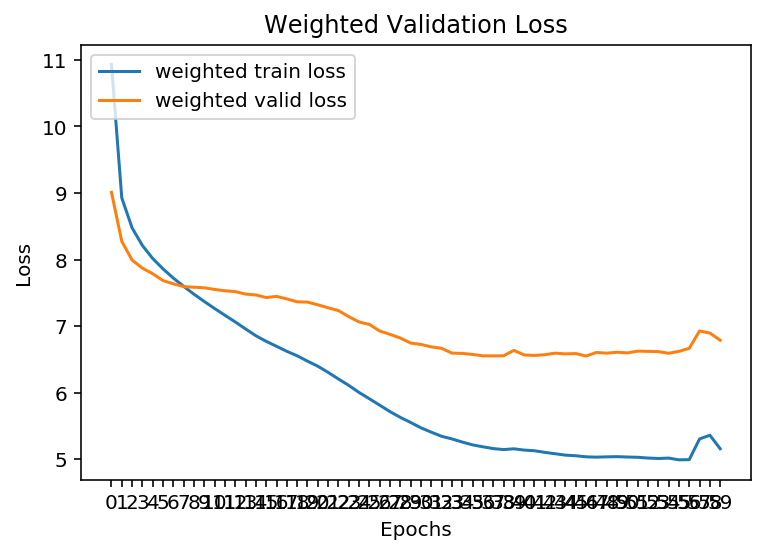

In [ ]:
# GRAPH WEIGHTED LOSSES

train_weighted_losses = np.array([ S['losses'] for S in train_stats]).mean(axis=1)
val_weighted_losses = np.array([ S['losses'] for S in val_stats]).mean(axis=1)


plt.plot(train_weighted_losses)
plt.plot(val_weighted_losses)
plt.xticks(range(len(val_weighted_losses)))

plt.title("Weighted Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(["weighted train loss", "weighted valid loss"], loc="upper left")
plt.show()

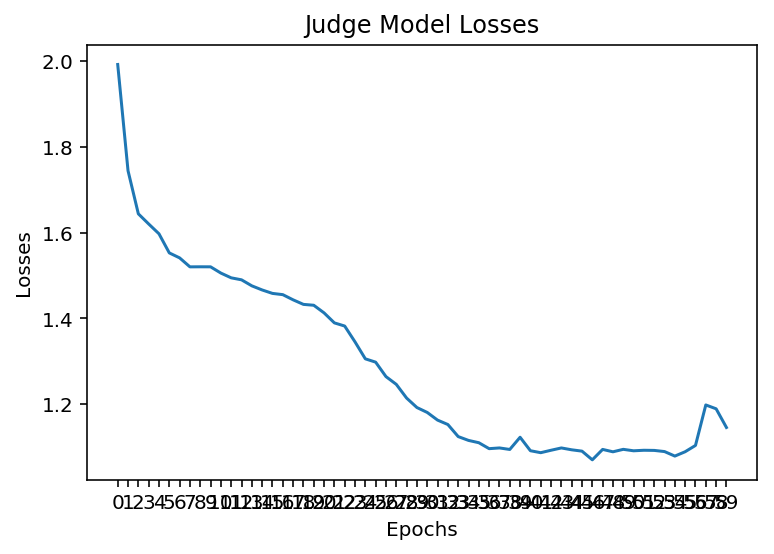

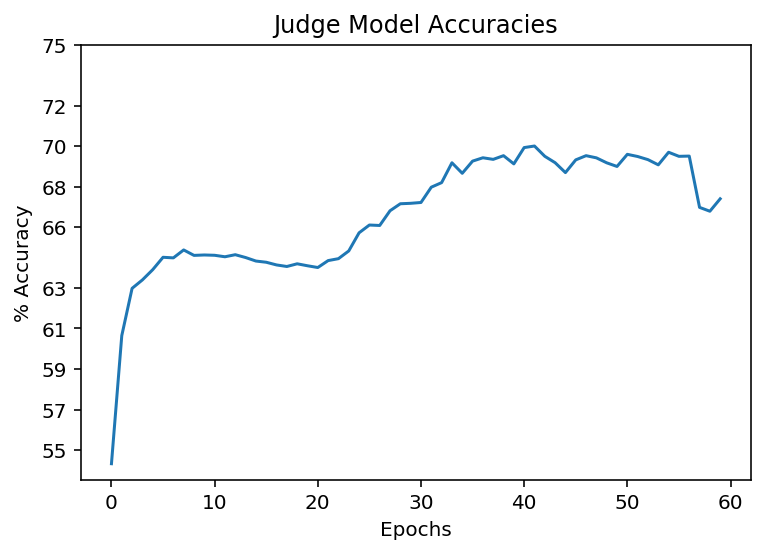

In [ ]:
val_judge_losses = np.array([ S['j_losses'] for S in val_stats]).mean(axis=1)
val_judge_accs = np.array([ S['j_accs'] for S in val_stats]).mean(axis=1)

plt.plot(val_judge_losses)
plt.xticks(range(len(val_judge_losses)))
plt.title("Judge Model Losses")
plt.xlabel('Epochs')
plt.ylabel('Losses')

plt.show()

plt.plot(val_judge_accs)
plt.yticks(np.linspace(55, 75, 10, dtype="int8"))
plt.title("Judge Model Accuracies")
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')

plt.show()

In [ ]:
# SAMPLING

if not "models" in vars() or models is None or len(models) < 2:
    mkdir(OUTPUT_PATH)
    # file location, update to point to the correct file
    MODELS_FILE_PATH = OUTPUT_PATH + "/12-09_21-52-24_7D4325.models"
    # which epoch's models to use
    NTH_EPOCH = val_weighted_losses.argmin()
    
    with open(MODELS_FILE_PATH, "rb") as file:
        saved_models = pickle.load(file)
        models = saved_models[NTH_EPOCH]
        
# how many ticks to sample, 16 ticks ~ 1 measure of music
NUM_TICKS_TO_SAMPLE = 512
# number of iterations to repeat the sampling process, one iteration
# will run for NUM_PARTS * NUM_TICKS_TO_SAMPLE times.
NUM_REPEATS = 12000
        
output = sample(models, 
                num_parts=NUM_PARTS,
                num_ticks=NUM_TICKS_TO_SAMPLE,
                num_dims=PITCH_VOCAB_SIZE,
                seq_len=SEQ_LEN,
                num_repeats=NUM_REPEATS)

current iter: 0/24576000
current iter: 1000/24576000
current iter: 2000/24576000
current iter: 3000/24576000
current iter: 4000/24576000
current iter: 5000/24576000
current iter: 6000/24576000
current iter: 7000/24576000
current iter: 8000/24576000
current iter: 9000/24576000
current iter: 10000/24576000
current iter: 11000/24576000
current iter: 12000/24576000
current iter: 13000/24576000
current iter: 14000/24576000
current iter: 15000/24576000
current iter: 16000/24576000
current iter: 17000/24576000
current iter: 18000/24576000
current iter: 19000/24576000
current iter: 20000/24576000
current iter: 21000/24576000
current iter: 22000/24576000
current iter: 23000/24576000
current iter: 24000/24576000
current iter: 25000/24576000
current iter: 26000/24576000
current iter: 27000/24576000
current iter: 28000/24576000
current iter: 29000/24576000
current iter: 30000/24576000
current iter: 31000/24576000
current iter: 32000/24576000
current iter: 33000/24576000
current iter: 34000/2457600

current iter: 277000/24576000
current iter: 278000/24576000
current iter: 279000/24576000
current iter: 280000/24576000
current iter: 281000/24576000
current iter: 282000/24576000
current iter: 283000/24576000
current iter: 284000/24576000
current iter: 285000/24576000
current iter: 286000/24576000
current iter: 287000/24576000
current iter: 288000/24576000
current iter: 289000/24576000
current iter: 290000/24576000
current iter: 291000/24576000
current iter: 292000/24576000
current iter: 293000/24576000
current iter: 294000/24576000
current iter: 295000/24576000
current iter: 296000/24576000
current iter: 297000/24576000
current iter: 298000/24576000
current iter: 299000/24576000
current iter: 300000/24576000
current iter: 301000/24576000
current iter: 302000/24576000
current iter: 303000/24576000
current iter: 304000/24576000
current iter: 305000/24576000
current iter: 306000/24576000
current iter: 307000/24576000
current iter: 308000/24576000
current iter: 309000/24576000
current it

current iter: 551000/24576000
current iter: 552000/24576000
current iter: 553000/24576000
current iter: 554000/24576000
current iter: 555000/24576000
current iter: 556000/24576000
current iter: 557000/24576000
current iter: 558000/24576000
current iter: 559000/24576000
current iter: 560000/24576000
current iter: 561000/24576000
current iter: 562000/24576000
current iter: 563000/24576000
current iter: 564000/24576000
current iter: 565000/24576000
current iter: 566000/24576000
current iter: 567000/24576000
current iter: 568000/24576000
current iter: 569000/24576000
current iter: 570000/24576000
current iter: 571000/24576000
current iter: 572000/24576000
current iter: 573000/24576000
current iter: 574000/24576000
current iter: 575000/24576000
current iter: 576000/24576000
current iter: 577000/24576000
current iter: 578000/24576000
current iter: 579000/24576000
current iter: 580000/24576000
current iter: 581000/24576000
current iter: 582000/24576000
current iter: 583000/24576000
current it

current iter: 825000/24576000
current iter: 826000/24576000
current iter: 827000/24576000
current iter: 828000/24576000
current iter: 829000/24576000
current iter: 830000/24576000
current iter: 831000/24576000
current iter: 832000/24576000
current iter: 833000/24576000
current iter: 834000/24576000
current iter: 835000/24576000
current iter: 836000/24576000
current iter: 837000/24576000
current iter: 838000/24576000
current iter: 839000/24576000
current iter: 840000/24576000
current iter: 841000/24576000
current iter: 842000/24576000
current iter: 843000/24576000
current iter: 844000/24576000
current iter: 845000/24576000
current iter: 846000/24576000
current iter: 847000/24576000
current iter: 848000/24576000
current iter: 849000/24576000
current iter: 850000/24576000
current iter: 851000/24576000
current iter: 852000/24576000
current iter: 853000/24576000
current iter: 854000/24576000
current iter: 855000/24576000
current iter: 856000/24576000
current iter: 857000/24576000
current it

current iter: 1095000/24576000
current iter: 1096000/24576000
current iter: 1097000/24576000
current iter: 1098000/24576000
current iter: 1099000/24576000
current iter: 1100000/24576000
current iter: 1101000/24576000
current iter: 1102000/24576000
current iter: 1103000/24576000
current iter: 1104000/24576000
current iter: 1105000/24576000
current iter: 1106000/24576000
current iter: 1107000/24576000
current iter: 1108000/24576000
current iter: 1109000/24576000
current iter: 1110000/24576000
current iter: 1111000/24576000
current iter: 1112000/24576000
current iter: 1113000/24576000
current iter: 1114000/24576000
current iter: 1115000/24576000
current iter: 1116000/24576000
current iter: 1117000/24576000
current iter: 1118000/24576000
current iter: 1119000/24576000
current iter: 1120000/24576000
current iter: 1121000/24576000
current iter: 1122000/24576000
current iter: 1123000/24576000
current iter: 1124000/24576000
current iter: 1125000/24576000
current iter: 1126000/24576000
current 

current iter: 1360000/24576000
current iter: 1361000/24576000
current iter: 1362000/24576000
current iter: 1363000/24576000
current iter: 1364000/24576000
current iter: 1365000/24576000
current iter: 1366000/24576000
current iter: 1367000/24576000
current iter: 1368000/24576000
current iter: 1369000/24576000
current iter: 1370000/24576000
current iter: 1371000/24576000
current iter: 1372000/24576000
current iter: 1373000/24576000
current iter: 1374000/24576000
current iter: 1375000/24576000
current iter: 1376000/24576000
current iter: 1377000/24576000
current iter: 1378000/24576000
current iter: 1379000/24576000
current iter: 1380000/24576000
current iter: 1381000/24576000
current iter: 1382000/24576000
current iter: 1383000/24576000
current iter: 1384000/24576000
current iter: 1385000/24576000
current iter: 1386000/24576000
current iter: 1387000/24576000
current iter: 1388000/24576000
current iter: 1389000/24576000
current iter: 1390000/24576000
current iter: 1391000/24576000
current 

current iter: 1625000/24576000
current iter: 1626000/24576000
current iter: 1627000/24576000
current iter: 1628000/24576000
current iter: 1629000/24576000
current iter: 1630000/24576000
current iter: 1631000/24576000
current iter: 1632000/24576000
current iter: 1633000/24576000
current iter: 1634000/24576000
current iter: 1635000/24576000
current iter: 1636000/24576000
current iter: 1637000/24576000
current iter: 1638000/24576000
current iter: 1639000/24576000
current iter: 1640000/24576000
current iter: 1641000/24576000
current iter: 1642000/24576000
current iter: 1643000/24576000
current iter: 1644000/24576000
current iter: 1645000/24576000
current iter: 1646000/24576000
current iter: 1647000/24576000
current iter: 1648000/24576000
current iter: 1649000/24576000
current iter: 1650000/24576000
current iter: 1651000/24576000
current iter: 1652000/24576000
current iter: 1653000/24576000
current iter: 1654000/24576000
current iter: 1655000/24576000
current iter: 1656000/24576000
current 

current iter: 1890000/24576000
current iter: 1891000/24576000
current iter: 1892000/24576000
current iter: 1893000/24576000
current iter: 1894000/24576000
current iter: 1895000/24576000
current iter: 1896000/24576000
current iter: 1897000/24576000
current iter: 1898000/24576000
current iter: 1899000/24576000
current iter: 1900000/24576000
current iter: 1901000/24576000
current iter: 1902000/24576000
current iter: 1903000/24576000
current iter: 1904000/24576000
current iter: 1905000/24576000
current iter: 1906000/24576000
current iter: 1907000/24576000
current iter: 1908000/24576000
current iter: 1909000/24576000
current iter: 1910000/24576000
current iter: 1911000/24576000
current iter: 1912000/24576000
current iter: 1913000/24576000
current iter: 1914000/24576000
current iter: 1915000/24576000
current iter: 1916000/24576000
current iter: 1917000/24576000
current iter: 1918000/24576000
current iter: 1919000/24576000
current iter: 1920000/24576000
current iter: 1921000/24576000
current 

current iter: 2155000/24576000
current iter: 2156000/24576000
current iter: 2157000/24576000
current iter: 2158000/24576000
current iter: 2159000/24576000
current iter: 2160000/24576000
current iter: 2161000/24576000
current iter: 2162000/24576000
current iter: 2163000/24576000
current iter: 2164000/24576000
current iter: 2165000/24576000
current iter: 2166000/24576000
current iter: 2167000/24576000
current iter: 2168000/24576000
current iter: 2169000/24576000
current iter: 2170000/24576000
current iter: 2171000/24576000
current iter: 2172000/24576000
current iter: 2173000/24576000
current iter: 2174000/24576000
current iter: 2175000/24576000
current iter: 2176000/24576000
current iter: 2177000/24576000
current iter: 2178000/24576000
current iter: 2179000/24576000
current iter: 2180000/24576000
current iter: 2181000/24576000
current iter: 2182000/24576000
current iter: 2183000/24576000
current iter: 2184000/24576000
current iter: 2185000/24576000
current iter: 2186000/24576000
current 

current iter: 2420000/24576000
current iter: 2421000/24576000
current iter: 2422000/24576000
current iter: 2423000/24576000
current iter: 2424000/24576000
current iter: 2425000/24576000
current iter: 2426000/24576000
current iter: 2427000/24576000
current iter: 2428000/24576000
current iter: 2429000/24576000
current iter: 2430000/24576000
current iter: 2431000/24576000
current iter: 2432000/24576000
current iter: 2433000/24576000
current iter: 2434000/24576000
current iter: 2435000/24576000
current iter: 2436000/24576000
current iter: 2437000/24576000
current iter: 2438000/24576000
current iter: 2439000/24576000
current iter: 2440000/24576000
current iter: 2441000/24576000
current iter: 2442000/24576000
current iter: 2443000/24576000
current iter: 2444000/24576000
current iter: 2445000/24576000
current iter: 2446000/24576000
current iter: 2447000/24576000
current iter: 2448000/24576000
current iter: 2449000/24576000
current iter: 2450000/24576000
current iter: 2451000/24576000
current 

current iter: 2685000/24576000
current iter: 2686000/24576000
current iter: 2687000/24576000
current iter: 2688000/24576000
current iter: 2689000/24576000
current iter: 2690000/24576000
current iter: 2691000/24576000
current iter: 2692000/24576000
current iter: 2693000/24576000
current iter: 2694000/24576000
current iter: 2695000/24576000
current iter: 2696000/24576000
current iter: 2697000/24576000
current iter: 2698000/24576000
current iter: 2699000/24576000
current iter: 2700000/24576000
current iter: 2701000/24576000
current iter: 2702000/24576000
current iter: 2703000/24576000
current iter: 2704000/24576000
current iter: 2705000/24576000
current iter: 2706000/24576000
current iter: 2707000/24576000
current iter: 2708000/24576000
current iter: 2709000/24576000
current iter: 2710000/24576000
current iter: 2711000/24576000
current iter: 2712000/24576000
current iter: 2713000/24576000
current iter: 2714000/24576000
current iter: 2715000/24576000
current iter: 2716000/24576000
current 

current iter: 2950000/24576000
current iter: 2951000/24576000
current iter: 2952000/24576000
current iter: 2953000/24576000
current iter: 2954000/24576000
current iter: 2955000/24576000
current iter: 2956000/24576000
current iter: 2957000/24576000
current iter: 2958000/24576000
current iter: 2959000/24576000
current iter: 2960000/24576000
current iter: 2961000/24576000
current iter: 2962000/24576000
current iter: 2963000/24576000
current iter: 2964000/24576000
current iter: 2965000/24576000
current iter: 2966000/24576000
current iter: 2967000/24576000
current iter: 2968000/24576000
current iter: 2969000/24576000
current iter: 2970000/24576000
current iter: 2971000/24576000
current iter: 2972000/24576000
current iter: 2973000/24576000
current iter: 2974000/24576000
current iter: 2975000/24576000
current iter: 2976000/24576000
current iter: 2977000/24576000
current iter: 2978000/24576000
current iter: 2979000/24576000
current iter: 2980000/24576000
current iter: 2981000/24576000
current 

current iter: 3215000/24576000
current iter: 3216000/24576000
current iter: 3217000/24576000
current iter: 3218000/24576000
current iter: 3219000/24576000
current iter: 3220000/24576000
current iter: 3221000/24576000
current iter: 3222000/24576000
current iter: 3223000/24576000
current iter: 3224000/24576000
current iter: 3225000/24576000
current iter: 3226000/24576000
current iter: 3227000/24576000
current iter: 3228000/24576000
current iter: 3229000/24576000
current iter: 3230000/24576000
current iter: 3231000/24576000
current iter: 3232000/24576000
current iter: 3233000/24576000
current iter: 3234000/24576000
current iter: 3235000/24576000
current iter: 3236000/24576000
current iter: 3237000/24576000
current iter: 3238000/24576000
current iter: 3239000/24576000
current iter: 3240000/24576000
current iter: 3241000/24576000
current iter: 3242000/24576000
current iter: 3243000/24576000
current iter: 3244000/24576000
current iter: 3245000/24576000
current iter: 3246000/24576000
current 

current iter: 3480000/24576000
current iter: 3481000/24576000
current iter: 3482000/24576000
current iter: 3483000/24576000
current iter: 3484000/24576000
current iter: 3485000/24576000
current iter: 3486000/24576000
current iter: 3487000/24576000
current iter: 3488000/24576000
current iter: 3489000/24576000
current iter: 3490000/24576000
current iter: 3491000/24576000
current iter: 3492000/24576000
current iter: 3493000/24576000
current iter: 3494000/24576000
current iter: 3495000/24576000
current iter: 3496000/24576000
current iter: 3497000/24576000
current iter: 3498000/24576000
current iter: 3499000/24576000
current iter: 3500000/24576000
current iter: 3501000/24576000
current iter: 3502000/24576000
current iter: 3503000/24576000
current iter: 3504000/24576000
current iter: 3505000/24576000
current iter: 3506000/24576000
current iter: 3507000/24576000
current iter: 3508000/24576000
current iter: 3509000/24576000
current iter: 3510000/24576000
current iter: 3511000/24576000
current 

current iter: 3745000/24576000
current iter: 3746000/24576000
current iter: 3747000/24576000
current iter: 3748000/24576000
current iter: 3749000/24576000
current iter: 3750000/24576000
current iter: 3751000/24576000
current iter: 3752000/24576000
current iter: 3753000/24576000
current iter: 3754000/24576000
current iter: 3755000/24576000
current iter: 3756000/24576000
current iter: 3757000/24576000
current iter: 3758000/24576000
current iter: 3759000/24576000
current iter: 3760000/24576000
current iter: 3761000/24576000
current iter: 3762000/24576000
current iter: 3763000/24576000
current iter: 3764000/24576000
current iter: 3765000/24576000
current iter: 3766000/24576000
current iter: 3767000/24576000
current iter: 3768000/24576000
current iter: 3769000/24576000
current iter: 3770000/24576000
current iter: 3771000/24576000
current iter: 3772000/24576000
current iter: 3773000/24576000
current iter: 3774000/24576000
current iter: 3775000/24576000
current iter: 3776000/24576000
current 

current iter: 4010000/24576000
current iter: 4011000/24576000
current iter: 4012000/24576000
current iter: 4013000/24576000
current iter: 4014000/24576000
current iter: 4015000/24576000
current iter: 4016000/24576000
current iter: 4017000/24576000
current iter: 4018000/24576000
current iter: 4019000/24576000
current iter: 4020000/24576000
current iter: 4021000/24576000
current iter: 4022000/24576000
current iter: 4023000/24576000
current iter: 4024000/24576000
current iter: 4025000/24576000
current iter: 4026000/24576000
current iter: 4027000/24576000
current iter: 4028000/24576000
current iter: 4029000/24576000
current iter: 4030000/24576000
current iter: 4031000/24576000
current iter: 4032000/24576000
current iter: 4033000/24576000
current iter: 4034000/24576000
current iter: 4035000/24576000
current iter: 4036000/24576000
current iter: 4037000/24576000
current iter: 4038000/24576000
current iter: 4039000/24576000
current iter: 4040000/24576000
current iter: 4041000/24576000
current 

current iter: 4275000/24576000
current iter: 4276000/24576000
current iter: 4277000/24576000
current iter: 4278000/24576000
current iter: 4279000/24576000
current iter: 4280000/24576000
current iter: 4281000/24576000
current iter: 4282000/24576000
current iter: 4283000/24576000
current iter: 4284000/24576000
current iter: 4285000/24576000
current iter: 4286000/24576000
current iter: 4287000/24576000
current iter: 4288000/24576000
current iter: 4289000/24576000
current iter: 4290000/24576000
current iter: 4291000/24576000
current iter: 4292000/24576000
current iter: 4293000/24576000
current iter: 4294000/24576000
current iter: 4295000/24576000
current iter: 4296000/24576000
current iter: 4297000/24576000
current iter: 4298000/24576000
current iter: 4299000/24576000
current iter: 4300000/24576000
current iter: 4301000/24576000
current iter: 4302000/24576000
current iter: 4303000/24576000
current iter: 4304000/24576000
current iter: 4305000/24576000
current iter: 4306000/24576000
current 

current iter: 4540000/24576000
current iter: 4541000/24576000
current iter: 4542000/24576000
current iter: 4543000/24576000
current iter: 4544000/24576000
current iter: 4545000/24576000
current iter: 4546000/24576000
current iter: 4547000/24576000
current iter: 4548000/24576000
current iter: 4549000/24576000
current iter: 4550000/24576000
current iter: 4551000/24576000
current iter: 4552000/24576000
current iter: 4553000/24576000
current iter: 4554000/24576000
current iter: 4555000/24576000
current iter: 4556000/24576000
current iter: 4557000/24576000
current iter: 4558000/24576000
current iter: 4559000/24576000
current iter: 4560000/24576000
current iter: 4561000/24576000
current iter: 4562000/24576000
current iter: 4563000/24576000
current iter: 4564000/24576000
current iter: 4565000/24576000
current iter: 4566000/24576000
current iter: 4567000/24576000
current iter: 4568000/24576000
current iter: 4569000/24576000
current iter: 4570000/24576000
current iter: 4571000/24576000
current 

current iter: 4805000/24576000
current iter: 4806000/24576000
current iter: 4807000/24576000
current iter: 4808000/24576000
current iter: 4809000/24576000
current iter: 4810000/24576000
current iter: 4811000/24576000
current iter: 4812000/24576000
current iter: 4813000/24576000
current iter: 4814000/24576000
current iter: 4815000/24576000
current iter: 4816000/24576000
current iter: 4817000/24576000
current iter: 4818000/24576000
current iter: 4819000/24576000
current iter: 4820000/24576000
current iter: 4821000/24576000
current iter: 4822000/24576000
current iter: 4823000/24576000
current iter: 4824000/24576000
current iter: 4825000/24576000
current iter: 4826000/24576000
current iter: 4827000/24576000
current iter: 4828000/24576000
current iter: 4829000/24576000
current iter: 4830000/24576000
current iter: 4831000/24576000
current iter: 4832000/24576000
current iter: 4833000/24576000
current iter: 4834000/24576000
current iter: 4835000/24576000
current iter: 4836000/24576000
current 

current iter: 5070000/24576000
current iter: 5071000/24576000
current iter: 5072000/24576000
current iter: 5073000/24576000
current iter: 5074000/24576000
current iter: 5075000/24576000
current iter: 5076000/24576000
current iter: 5077000/24576000
current iter: 5078000/24576000
current iter: 5079000/24576000
current iter: 5080000/24576000
current iter: 5081000/24576000
current iter: 5082000/24576000
current iter: 5083000/24576000
current iter: 5084000/24576000
current iter: 5085000/24576000
current iter: 5086000/24576000
current iter: 5087000/24576000
current iter: 5088000/24576000
current iter: 5089000/24576000
current iter: 5090000/24576000
current iter: 5091000/24576000
current iter: 5092000/24576000
current iter: 5093000/24576000
current iter: 5094000/24576000
current iter: 5095000/24576000
current iter: 5096000/24576000
current iter: 5097000/24576000
current iter: 5098000/24576000
current iter: 5099000/24576000
current iter: 5100000/24576000
current iter: 5101000/24576000
current 

current iter: 5335000/24576000
current iter: 5336000/24576000
current iter: 5337000/24576000
current iter: 5338000/24576000
current iter: 5339000/24576000
current iter: 5340000/24576000
current iter: 5341000/24576000
current iter: 5342000/24576000
current iter: 5343000/24576000
current iter: 5344000/24576000
current iter: 5345000/24576000
current iter: 5346000/24576000
current iter: 5347000/24576000
current iter: 5348000/24576000
current iter: 5349000/24576000
current iter: 5350000/24576000
current iter: 5351000/24576000
current iter: 5352000/24576000
current iter: 5353000/24576000
current iter: 5354000/24576000
current iter: 5355000/24576000
current iter: 5356000/24576000
current iter: 5357000/24576000
current iter: 5358000/24576000
current iter: 5359000/24576000
current iter: 5360000/24576000
current iter: 5361000/24576000
current iter: 5362000/24576000
current iter: 5363000/24576000
current iter: 5364000/24576000
current iter: 5365000/24576000
current iter: 5366000/24576000
current 

current iter: 5600000/24576000
current iter: 5601000/24576000
current iter: 5602000/24576000
current iter: 5603000/24576000
current iter: 5604000/24576000
current iter: 5605000/24576000
current iter: 5606000/24576000
current iter: 5607000/24576000
current iter: 5608000/24576000
current iter: 5609000/24576000
current iter: 5610000/24576000
current iter: 5611000/24576000
current iter: 5612000/24576000
current iter: 5613000/24576000
current iter: 5614000/24576000
current iter: 5615000/24576000
current iter: 5616000/24576000
current iter: 5617000/24576000
current iter: 5618000/24576000
current iter: 5619000/24576000
current iter: 5620000/24576000
current iter: 5621000/24576000
current iter: 5622000/24576000
current iter: 5623000/24576000
current iter: 5624000/24576000
current iter: 5625000/24576000
current iter: 5626000/24576000
current iter: 5627000/24576000
current iter: 5628000/24576000
current iter: 5629000/24576000
current iter: 5630000/24576000
current iter: 5631000/24576000
current 

current iter: 5865000/24576000
current iter: 5866000/24576000
current iter: 5867000/24576000
current iter: 5868000/24576000
current iter: 5869000/24576000
current iter: 5870000/24576000
current iter: 5871000/24576000
current iter: 5872000/24576000
current iter: 5873000/24576000
current iter: 5874000/24576000
current iter: 5875000/24576000
current iter: 5876000/24576000
current iter: 5877000/24576000
current iter: 5878000/24576000
current iter: 5879000/24576000
current iter: 5880000/24576000
current iter: 5881000/24576000
current iter: 5882000/24576000
current iter: 5883000/24576000
current iter: 5884000/24576000
current iter: 5885000/24576000
current iter: 5886000/24576000
current iter: 5887000/24576000
current iter: 5888000/24576000
current iter: 5889000/24576000
current iter: 5890000/24576000
current iter: 5891000/24576000
current iter: 5892000/24576000
current iter: 5893000/24576000
current iter: 5894000/24576000
current iter: 5895000/24576000
current iter: 5896000/24576000
current 

current iter: 6130000/24576000
current iter: 6131000/24576000
current iter: 6132000/24576000
current iter: 6133000/24576000
current iter: 6134000/24576000
current iter: 6135000/24576000
current iter: 6136000/24576000
current iter: 6137000/24576000
current iter: 6138000/24576000
current iter: 6139000/24576000
current iter: 6140000/24576000
current iter: 6141000/24576000
current iter: 6142000/24576000
current iter: 6143000/24576000
current iter: 6144000/24576000
current iter: 6145000/24576000
current iter: 6146000/24576000
current iter: 6147000/24576000
current iter: 6148000/24576000
current iter: 6149000/24576000
current iter: 6150000/24576000
current iter: 6151000/24576000
current iter: 6152000/24576000
current iter: 6153000/24576000
current iter: 6154000/24576000
current iter: 6155000/24576000
current iter: 6156000/24576000
current iter: 6157000/24576000
current iter: 6158000/24576000
current iter: 6159000/24576000
current iter: 6160000/24576000
current iter: 6161000/24576000
current 

current iter: 6395000/24576000
current iter: 6396000/24576000
current iter: 6397000/24576000
current iter: 6398000/24576000
current iter: 6399000/24576000
current iter: 6400000/24576000
current iter: 6401000/24576000
current iter: 6402000/24576000
current iter: 6403000/24576000
current iter: 6404000/24576000
current iter: 6405000/24576000
current iter: 6406000/24576000
current iter: 6407000/24576000
current iter: 6408000/24576000
current iter: 6409000/24576000
current iter: 6410000/24576000
current iter: 6411000/24576000
current iter: 6412000/24576000
current iter: 6413000/24576000
current iter: 6414000/24576000
current iter: 6415000/24576000
current iter: 6416000/24576000
current iter: 6417000/24576000
current iter: 6418000/24576000
current iter: 6419000/24576000
current iter: 6420000/24576000
current iter: 6421000/24576000
current iter: 6422000/24576000
current iter: 6423000/24576000
current iter: 6424000/24576000
current iter: 6425000/24576000
current iter: 6426000/24576000
current 

current iter: 6660000/24576000
current iter: 6661000/24576000
current iter: 6662000/24576000
current iter: 6663000/24576000
current iter: 6664000/24576000
current iter: 6665000/24576000
current iter: 6666000/24576000
current iter: 6667000/24576000
current iter: 6668000/24576000
current iter: 6669000/24576000
current iter: 6670000/24576000
current iter: 6671000/24576000
current iter: 6672000/24576000
current iter: 6673000/24576000
current iter: 6674000/24576000
current iter: 6675000/24576000
current iter: 6676000/24576000
current iter: 6677000/24576000
current iter: 6678000/24576000
current iter: 6679000/24576000
current iter: 6680000/24576000
current iter: 6681000/24576000
current iter: 6682000/24576000
current iter: 6683000/24576000
current iter: 6684000/24576000
current iter: 6685000/24576000
current iter: 6686000/24576000
current iter: 6687000/24576000
current iter: 6688000/24576000
current iter: 6689000/24576000
current iter: 6690000/24576000
current iter: 6691000/24576000
current 

current iter: 6925000/24576000
current iter: 6926000/24576000
current iter: 6927000/24576000
current iter: 6928000/24576000
current iter: 6929000/24576000
current iter: 6930000/24576000
current iter: 6931000/24576000
current iter: 6932000/24576000
current iter: 6933000/24576000
current iter: 6934000/24576000
current iter: 6935000/24576000
current iter: 6936000/24576000
current iter: 6937000/24576000
current iter: 6938000/24576000
current iter: 6939000/24576000
current iter: 6940000/24576000
current iter: 6941000/24576000
current iter: 6942000/24576000
current iter: 6943000/24576000
current iter: 6944000/24576000
current iter: 6945000/24576000
current iter: 6946000/24576000
current iter: 6947000/24576000
current iter: 6948000/24576000
current iter: 6949000/24576000
current iter: 6950000/24576000
current iter: 6951000/24576000
current iter: 6952000/24576000
current iter: 6953000/24576000
current iter: 6954000/24576000
current iter: 6955000/24576000
current iter: 6956000/24576000
current 

current iter: 7190000/24576000
current iter: 7191000/24576000
current iter: 7192000/24576000
current iter: 7193000/24576000
current iter: 7194000/24576000
current iter: 7195000/24576000
current iter: 7196000/24576000
current iter: 7197000/24576000
current iter: 7198000/24576000
current iter: 7199000/24576000
current iter: 7200000/24576000
current iter: 7201000/24576000
current iter: 7202000/24576000
current iter: 7203000/24576000
current iter: 7204000/24576000
current iter: 7205000/24576000
current iter: 7206000/24576000
current iter: 7207000/24576000
current iter: 7208000/24576000
current iter: 7209000/24576000
current iter: 7210000/24576000
current iter: 7211000/24576000
current iter: 7212000/24576000
current iter: 7213000/24576000
current iter: 7214000/24576000
current iter: 7215000/24576000
current iter: 7216000/24576000
current iter: 7217000/24576000
current iter: 7218000/24576000
current iter: 7219000/24576000
current iter: 7220000/24576000
current iter: 7221000/24576000
current 

current iter: 7455000/24576000
current iter: 7456000/24576000
current iter: 7457000/24576000
current iter: 7458000/24576000
current iter: 7459000/24576000
current iter: 7460000/24576000
current iter: 7461000/24576000
current iter: 7462000/24576000
current iter: 7463000/24576000
current iter: 7464000/24576000
current iter: 7465000/24576000
current iter: 7466000/24576000
current iter: 7467000/24576000
current iter: 7468000/24576000
current iter: 7469000/24576000
current iter: 7470000/24576000
current iter: 7471000/24576000
current iter: 7472000/24576000
current iter: 7473000/24576000
current iter: 7474000/24576000
current iter: 7475000/24576000
current iter: 7476000/24576000
current iter: 7477000/24576000
current iter: 7478000/24576000
current iter: 7479000/24576000
current iter: 7480000/24576000
current iter: 7481000/24576000
current iter: 7482000/24576000
current iter: 7483000/24576000
current iter: 7484000/24576000
current iter: 7485000/24576000
current iter: 7486000/24576000
current 

current iter: 7720000/24576000
current iter: 7721000/24576000
current iter: 7722000/24576000
current iter: 7723000/24576000
current iter: 7724000/24576000
current iter: 7725000/24576000
current iter: 7726000/24576000
current iter: 7727000/24576000
current iter: 7728000/24576000
current iter: 7729000/24576000
current iter: 7730000/24576000
current iter: 7731000/24576000
current iter: 7732000/24576000
current iter: 7733000/24576000
current iter: 7734000/24576000
current iter: 7735000/24576000
current iter: 7736000/24576000
current iter: 7737000/24576000
current iter: 7738000/24576000
current iter: 7739000/24576000
current iter: 7740000/24576000
current iter: 7741000/24576000
current iter: 7742000/24576000
current iter: 7743000/24576000
current iter: 7744000/24576000
current iter: 7745000/24576000
current iter: 7746000/24576000
current iter: 7747000/24576000
current iter: 7748000/24576000
current iter: 7749000/24576000
current iter: 7750000/24576000
current iter: 7751000/24576000
current 

current iter: 7985000/24576000
current iter: 7986000/24576000
current iter: 7987000/24576000
current iter: 7988000/24576000
current iter: 7989000/24576000
current iter: 7990000/24576000
current iter: 7991000/24576000
current iter: 7992000/24576000
current iter: 7993000/24576000
current iter: 7994000/24576000
current iter: 7995000/24576000
current iter: 7996000/24576000
current iter: 7997000/24576000
current iter: 7998000/24576000
current iter: 7999000/24576000
current iter: 8000000/24576000
current iter: 8001000/24576000
current iter: 8002000/24576000
current iter: 8003000/24576000
current iter: 8004000/24576000
current iter: 8005000/24576000
current iter: 8006000/24576000
current iter: 8007000/24576000
current iter: 8008000/24576000
current iter: 8009000/24576000
current iter: 8010000/24576000
current iter: 8011000/24576000
current iter: 8012000/24576000
current iter: 8013000/24576000
current iter: 8014000/24576000
current iter: 8015000/24576000
current iter: 8016000/24576000
current 

current iter: 8250000/24576000
current iter: 8251000/24576000
current iter: 8252000/24576000
current iter: 8253000/24576000
current iter: 8254000/24576000
current iter: 8255000/24576000
current iter: 8256000/24576000
current iter: 8257000/24576000
current iter: 8258000/24576000
current iter: 8259000/24576000
current iter: 8260000/24576000
current iter: 8261000/24576000
current iter: 8262000/24576000
current iter: 8263000/24576000
current iter: 8264000/24576000
current iter: 8265000/24576000
current iter: 8266000/24576000
current iter: 8267000/24576000
current iter: 8268000/24576000
current iter: 8269000/24576000
current iter: 8270000/24576000
current iter: 8271000/24576000
current iter: 8272000/24576000
current iter: 8273000/24576000
current iter: 8274000/24576000
current iter: 8275000/24576000
current iter: 8276000/24576000
current iter: 8277000/24576000
current iter: 8278000/24576000
current iter: 8279000/24576000
current iter: 8280000/24576000
current iter: 8281000/24576000
current 

current iter: 8515000/24576000
current iter: 8516000/24576000
current iter: 8517000/24576000
current iter: 8518000/24576000
current iter: 8519000/24576000
current iter: 8520000/24576000
current iter: 8521000/24576000
current iter: 8522000/24576000
current iter: 8523000/24576000
current iter: 8524000/24576000
current iter: 8525000/24576000
current iter: 8526000/24576000
current iter: 8527000/24576000
current iter: 8528000/24576000
current iter: 8529000/24576000
current iter: 8530000/24576000
current iter: 8531000/24576000
current iter: 8532000/24576000
current iter: 8533000/24576000
current iter: 8534000/24576000
current iter: 8535000/24576000
current iter: 8536000/24576000
current iter: 8537000/24576000
current iter: 8538000/24576000
current iter: 8539000/24576000
current iter: 8540000/24576000
current iter: 8541000/24576000
current iter: 8542000/24576000
current iter: 8543000/24576000
current iter: 8544000/24576000
current iter: 8545000/24576000
current iter: 8546000/24576000
current 

current iter: 8780000/24576000
current iter: 8781000/24576000
current iter: 8782000/24576000
current iter: 8783000/24576000
current iter: 8784000/24576000
current iter: 8785000/24576000
current iter: 8786000/24576000
current iter: 8787000/24576000
current iter: 8788000/24576000
current iter: 8789000/24576000
current iter: 8790000/24576000
current iter: 8791000/24576000
current iter: 8792000/24576000
current iter: 8793000/24576000
current iter: 8794000/24576000
current iter: 8795000/24576000
current iter: 8796000/24576000
current iter: 8797000/24576000
current iter: 8798000/24576000
current iter: 8799000/24576000
current iter: 8800000/24576000
current iter: 8801000/24576000
current iter: 8802000/24576000
current iter: 8803000/24576000
current iter: 8804000/24576000
current iter: 8805000/24576000
current iter: 8806000/24576000
current iter: 8807000/24576000
current iter: 8808000/24576000
current iter: 8809000/24576000
current iter: 8810000/24576000
current iter: 8811000/24576000
current 

current iter: 9045000/24576000
current iter: 9046000/24576000
current iter: 9047000/24576000
current iter: 9048000/24576000
current iter: 9049000/24576000
current iter: 9050000/24576000
current iter: 9051000/24576000
current iter: 9052000/24576000
current iter: 9053000/24576000
current iter: 9054000/24576000
current iter: 9055000/24576000
current iter: 9056000/24576000
current iter: 9057000/24576000
current iter: 9058000/24576000
current iter: 9059000/24576000
current iter: 9060000/24576000
current iter: 9061000/24576000
current iter: 9062000/24576000
current iter: 9063000/24576000
current iter: 9064000/24576000
current iter: 9065000/24576000
current iter: 9066000/24576000
current iter: 9067000/24576000
current iter: 9068000/24576000
current iter: 9069000/24576000
current iter: 9070000/24576000
current iter: 9071000/24576000
current iter: 9072000/24576000
current iter: 9073000/24576000
current iter: 9074000/24576000
current iter: 9075000/24576000
current iter: 9076000/24576000
current 

current iter: 9310000/24576000
current iter: 9311000/24576000
current iter: 9312000/24576000
current iter: 9313000/24576000
current iter: 9314000/24576000
current iter: 9315000/24576000
current iter: 9316000/24576000
current iter: 9317000/24576000
current iter: 9318000/24576000
current iter: 9319000/24576000
current iter: 9320000/24576000
current iter: 9321000/24576000
current iter: 9322000/24576000
current iter: 9323000/24576000
current iter: 9324000/24576000
current iter: 9325000/24576000
current iter: 9326000/24576000
current iter: 9327000/24576000
current iter: 9328000/24576000
current iter: 9329000/24576000
current iter: 9330000/24576000
current iter: 9331000/24576000
current iter: 9332000/24576000
current iter: 9333000/24576000
current iter: 9334000/24576000
current iter: 9335000/24576000
current iter: 9336000/24576000
current iter: 9337000/24576000
current iter: 9338000/24576000
current iter: 9339000/24576000
current iter: 9340000/24576000
current iter: 9341000/24576000
current 

current iter: 9575000/24576000
current iter: 9576000/24576000
current iter: 9577000/24576000
current iter: 9578000/24576000
current iter: 9579000/24576000
current iter: 9580000/24576000
current iter: 9581000/24576000
current iter: 9582000/24576000
current iter: 9583000/24576000
current iter: 9584000/24576000
current iter: 9585000/24576000
current iter: 9586000/24576000
current iter: 9587000/24576000
current iter: 9588000/24576000
current iter: 9589000/24576000
current iter: 9590000/24576000
current iter: 9591000/24576000
current iter: 9592000/24576000
current iter: 9593000/24576000
current iter: 9594000/24576000
current iter: 9595000/24576000
current iter: 9596000/24576000
current iter: 9597000/24576000
current iter: 9598000/24576000
current iter: 9599000/24576000
current iter: 9600000/24576000
current iter: 9601000/24576000
current iter: 9602000/24576000
current iter: 9603000/24576000
current iter: 9604000/24576000
current iter: 9605000/24576000
current iter: 9606000/24576000
current 

current iter: 9840000/24576000
current iter: 9841000/24576000
current iter: 9842000/24576000
current iter: 9843000/24576000
current iter: 9844000/24576000
current iter: 9845000/24576000
current iter: 9846000/24576000
current iter: 9847000/24576000
current iter: 9848000/24576000
current iter: 9849000/24576000
current iter: 9850000/24576000
current iter: 9851000/24576000
current iter: 9852000/24576000
current iter: 9853000/24576000
current iter: 9854000/24576000
current iter: 9855000/24576000
current iter: 9856000/24576000
current iter: 9857000/24576000
current iter: 9858000/24576000
current iter: 9859000/24576000
current iter: 9860000/24576000
current iter: 9861000/24576000
current iter: 9862000/24576000
current iter: 9863000/24576000
current iter: 9864000/24576000
current iter: 9865000/24576000
current iter: 9866000/24576000
current iter: 9867000/24576000
current iter: 9868000/24576000
current iter: 9869000/24576000
current iter: 9870000/24576000
current iter: 9871000/24576000
current 

current iter: 10102000/24576000
current iter: 10103000/24576000
current iter: 10104000/24576000
current iter: 10105000/24576000
current iter: 10106000/24576000
current iter: 10107000/24576000
current iter: 10108000/24576000
current iter: 10109000/24576000
current iter: 10110000/24576000
current iter: 10111000/24576000
current iter: 10112000/24576000
current iter: 10113000/24576000
current iter: 10114000/24576000
current iter: 10115000/24576000
current iter: 10116000/24576000
current iter: 10117000/24576000
current iter: 10118000/24576000
current iter: 10119000/24576000
current iter: 10120000/24576000
current iter: 10121000/24576000
current iter: 10122000/24576000
current iter: 10123000/24576000
current iter: 10124000/24576000
current iter: 10125000/24576000
current iter: 10126000/24576000
current iter: 10127000/24576000
current iter: 10128000/24576000
current iter: 10129000/24576000
current iter: 10130000/24576000
current iter: 10131000/24576000
current iter: 10132000/24576000
current 

current iter: 10359000/24576000
current iter: 10360000/24576000
current iter: 10361000/24576000
current iter: 10362000/24576000
current iter: 10363000/24576000
current iter: 10364000/24576000
current iter: 10365000/24576000
current iter: 10366000/24576000
current iter: 10367000/24576000
current iter: 10368000/24576000
current iter: 10369000/24576000
current iter: 10370000/24576000
current iter: 10371000/24576000
current iter: 10372000/24576000
current iter: 10373000/24576000
current iter: 10374000/24576000
current iter: 10375000/24576000
current iter: 10376000/24576000
current iter: 10377000/24576000
current iter: 10378000/24576000
current iter: 10379000/24576000
current iter: 10380000/24576000
current iter: 10381000/24576000
current iter: 10382000/24576000
current iter: 10383000/24576000
current iter: 10384000/24576000
current iter: 10385000/24576000
current iter: 10386000/24576000
current iter: 10387000/24576000
current iter: 10388000/24576000
current iter: 10389000/24576000
current 

current iter: 10616000/24576000
current iter: 10617000/24576000
current iter: 10618000/24576000
current iter: 10619000/24576000
current iter: 10620000/24576000
current iter: 10621000/24576000
current iter: 10622000/24576000
current iter: 10623000/24576000
current iter: 10624000/24576000
current iter: 10625000/24576000
current iter: 10626000/24576000
current iter: 10627000/24576000
current iter: 10628000/24576000
current iter: 10629000/24576000
current iter: 10630000/24576000
current iter: 10631000/24576000
current iter: 10632000/24576000
current iter: 10633000/24576000
current iter: 10634000/24576000
current iter: 10635000/24576000
current iter: 10636000/24576000
current iter: 10637000/24576000
current iter: 10638000/24576000
current iter: 10639000/24576000
current iter: 10640000/24576000
current iter: 10641000/24576000
current iter: 10642000/24576000
current iter: 10643000/24576000
current iter: 10644000/24576000
current iter: 10645000/24576000
current iter: 10646000/24576000
current 

current iter: 10873000/24576000
current iter: 10874000/24576000
current iter: 10875000/24576000
current iter: 10876000/24576000
current iter: 10877000/24576000
current iter: 10878000/24576000
current iter: 10879000/24576000
current iter: 10880000/24576000
current iter: 10881000/24576000
current iter: 10882000/24576000
current iter: 10883000/24576000
current iter: 10884000/24576000
current iter: 10885000/24576000
current iter: 10886000/24576000
current iter: 10887000/24576000
current iter: 10888000/24576000
current iter: 10889000/24576000
current iter: 10890000/24576000
current iter: 10891000/24576000
current iter: 10892000/24576000
current iter: 10893000/24576000
current iter: 10894000/24576000
current iter: 10895000/24576000
current iter: 10896000/24576000
current iter: 10897000/24576000
current iter: 10898000/24576000
current iter: 10899000/24576000
current iter: 10900000/24576000
current iter: 10901000/24576000
current iter: 10902000/24576000
current iter: 10903000/24576000
current 

current iter: 11130000/24576000
current iter: 11131000/24576000
current iter: 11132000/24576000
current iter: 11133000/24576000
current iter: 11134000/24576000
current iter: 11135000/24576000
current iter: 11136000/24576000
current iter: 11137000/24576000
current iter: 11138000/24576000
current iter: 11139000/24576000
current iter: 11140000/24576000
current iter: 11141000/24576000
current iter: 11142000/24576000
current iter: 11143000/24576000
current iter: 11144000/24576000
current iter: 11145000/24576000
current iter: 11146000/24576000
current iter: 11147000/24576000
current iter: 11148000/24576000
current iter: 11149000/24576000
current iter: 11150000/24576000
current iter: 11151000/24576000
current iter: 11152000/24576000
current iter: 11153000/24576000
current iter: 11154000/24576000
current iter: 11155000/24576000
current iter: 11156000/24576000
current iter: 11157000/24576000
current iter: 11158000/24576000
current iter: 11159000/24576000
current iter: 11160000/24576000
current 

current iter: 11387000/24576000
current iter: 11388000/24576000
current iter: 11389000/24576000
current iter: 11390000/24576000
current iter: 11391000/24576000
current iter: 11392000/24576000
current iter: 11393000/24576000
current iter: 11394000/24576000
current iter: 11395000/24576000
current iter: 11396000/24576000
current iter: 11397000/24576000
current iter: 11398000/24576000
current iter: 11399000/24576000
current iter: 11400000/24576000
current iter: 11401000/24576000
current iter: 11402000/24576000
current iter: 11403000/24576000
current iter: 11404000/24576000
current iter: 11405000/24576000
current iter: 11406000/24576000
current iter: 11407000/24576000
current iter: 11408000/24576000
current iter: 11409000/24576000
current iter: 11410000/24576000
current iter: 11411000/24576000
current iter: 11412000/24576000
current iter: 11413000/24576000
current iter: 11414000/24576000
current iter: 11415000/24576000
current iter: 11416000/24576000
current iter: 11417000/24576000
current 

current iter: 11644000/24576000
current iter: 11645000/24576000
current iter: 11646000/24576000
current iter: 11647000/24576000
current iter: 11648000/24576000
current iter: 11649000/24576000
current iter: 11650000/24576000
current iter: 11651000/24576000
current iter: 11652000/24576000
current iter: 11653000/24576000
current iter: 11654000/24576000
current iter: 11655000/24576000
current iter: 11656000/24576000
current iter: 11657000/24576000
current iter: 11658000/24576000
current iter: 11659000/24576000
current iter: 11660000/24576000
current iter: 11661000/24576000
current iter: 11662000/24576000
current iter: 11663000/24576000
current iter: 11664000/24576000
current iter: 11665000/24576000
current iter: 11666000/24576000
current iter: 11667000/24576000
current iter: 11668000/24576000
current iter: 11669000/24576000
current iter: 11670000/24576000
current iter: 11671000/24576000
current iter: 11672000/24576000
current iter: 11673000/24576000
current iter: 11674000/24576000
current 

current iter: 11901000/24576000
current iter: 11902000/24576000
current iter: 11903000/24576000
current iter: 11904000/24576000
current iter: 11905000/24576000
current iter: 11906000/24576000
current iter: 11907000/24576000
current iter: 11908000/24576000
current iter: 11909000/24576000
current iter: 11910000/24576000
current iter: 11911000/24576000
current iter: 11912000/24576000
current iter: 11913000/24576000
current iter: 11914000/24576000
current iter: 11915000/24576000
current iter: 11916000/24576000
current iter: 11917000/24576000
current iter: 11918000/24576000
current iter: 11919000/24576000
current iter: 11920000/24576000
current iter: 11921000/24576000
current iter: 11922000/24576000
current iter: 11923000/24576000
current iter: 11924000/24576000
current iter: 11925000/24576000
current iter: 11926000/24576000
current iter: 11927000/24576000
current iter: 11928000/24576000
current iter: 11929000/24576000
current iter: 11930000/24576000
current iter: 11931000/24576000
current 

current iter: 12158000/24576000
current iter: 12159000/24576000
current iter: 12160000/24576000
current iter: 12161000/24576000
current iter: 12162000/24576000
current iter: 12163000/24576000
current iter: 12164000/24576000
current iter: 12165000/24576000
current iter: 12166000/24576000
current iter: 12167000/24576000
current iter: 12168000/24576000
current iter: 12169000/24576000
current iter: 12170000/24576000
current iter: 12171000/24576000
current iter: 12172000/24576000
current iter: 12173000/24576000
current iter: 12174000/24576000
current iter: 12175000/24576000
current iter: 12176000/24576000
current iter: 12177000/24576000
current iter: 12178000/24576000
current iter: 12179000/24576000
current iter: 12180000/24576000
current iter: 12181000/24576000
current iter: 12182000/24576000
current iter: 12183000/24576000
current iter: 12184000/24576000
current iter: 12185000/24576000
current iter: 12186000/24576000
current iter: 12187000/24576000
current iter: 12188000/24576000
current 

current iter: 12415000/24576000
current iter: 12416000/24576000
current iter: 12417000/24576000
current iter: 12418000/24576000
current iter: 12419000/24576000
current iter: 12420000/24576000
current iter: 12421000/24576000
current iter: 12422000/24576000
current iter: 12423000/24576000
current iter: 12424000/24576000
current iter: 12425000/24576000
current iter: 12426000/24576000
current iter: 12427000/24576000
current iter: 12428000/24576000
current iter: 12429000/24576000
current iter: 12430000/24576000
current iter: 12431000/24576000
current iter: 12432000/24576000
current iter: 12433000/24576000
current iter: 12434000/24576000
current iter: 12435000/24576000
current iter: 12436000/24576000
current iter: 12437000/24576000
current iter: 12438000/24576000
current iter: 12439000/24576000
current iter: 12440000/24576000
current iter: 12441000/24576000
current iter: 12442000/24576000
current iter: 12443000/24576000
current iter: 12444000/24576000
current iter: 12445000/24576000
current 

current iter: 12672000/24576000
current iter: 12673000/24576000
current iter: 12674000/24576000
current iter: 12675000/24576000
current iter: 12676000/24576000
current iter: 12677000/24576000
current iter: 12678000/24576000
current iter: 12679000/24576000
current iter: 12680000/24576000
current iter: 12681000/24576000
current iter: 12682000/24576000
current iter: 12683000/24576000
current iter: 12684000/24576000
current iter: 12685000/24576000
current iter: 12686000/24576000
current iter: 12687000/24576000
current iter: 12688000/24576000
current iter: 12689000/24576000
current iter: 12690000/24576000
current iter: 12691000/24576000
current iter: 12692000/24576000
current iter: 12693000/24576000
current iter: 12694000/24576000
current iter: 12695000/24576000
current iter: 12696000/24576000
current iter: 12697000/24576000
current iter: 12698000/24576000
current iter: 12699000/24576000
current iter: 12700000/24576000
current iter: 12701000/24576000
current iter: 12702000/24576000
current 

current iter: 12929000/24576000
current iter: 12930000/24576000
current iter: 12931000/24576000
current iter: 12932000/24576000
current iter: 12933000/24576000
current iter: 12934000/24576000
current iter: 12935000/24576000
current iter: 12936000/24576000
current iter: 12937000/24576000
current iter: 12938000/24576000
current iter: 12939000/24576000
current iter: 12940000/24576000
current iter: 12941000/24576000
current iter: 12942000/24576000
current iter: 12943000/24576000
current iter: 12944000/24576000
current iter: 12945000/24576000
current iter: 12946000/24576000
current iter: 12947000/24576000
current iter: 12948000/24576000
current iter: 12949000/24576000
current iter: 12950000/24576000
current iter: 12951000/24576000
current iter: 12952000/24576000
current iter: 12953000/24576000
current iter: 12954000/24576000
current iter: 12955000/24576000
current iter: 12956000/24576000
current iter: 12957000/24576000
current iter: 12958000/24576000
current iter: 12959000/24576000
current 

current iter: 13186000/24576000
current iter: 13187000/24576000
current iter: 13188000/24576000
current iter: 13189000/24576000
current iter: 13190000/24576000
current iter: 13191000/24576000
current iter: 13192000/24576000
current iter: 13193000/24576000
current iter: 13194000/24576000
current iter: 13195000/24576000
current iter: 13196000/24576000
current iter: 13197000/24576000
current iter: 13198000/24576000
current iter: 13199000/24576000
current iter: 13200000/24576000
current iter: 13201000/24576000
current iter: 13202000/24576000
current iter: 13203000/24576000
current iter: 13204000/24576000
current iter: 13205000/24576000
current iter: 13206000/24576000
current iter: 13207000/24576000
current iter: 13208000/24576000
current iter: 13209000/24576000
current iter: 13210000/24576000
current iter: 13211000/24576000
current iter: 13212000/24576000
current iter: 13213000/24576000
current iter: 13214000/24576000
current iter: 13215000/24576000
current iter: 13216000/24576000
current 

current iter: 13443000/24576000
current iter: 13444000/24576000
current iter: 13445000/24576000
current iter: 13446000/24576000
current iter: 13447000/24576000
current iter: 13448000/24576000
current iter: 13449000/24576000
current iter: 13450000/24576000
current iter: 13451000/24576000
current iter: 13452000/24576000
current iter: 13453000/24576000
current iter: 13454000/24576000
current iter: 13455000/24576000
current iter: 13456000/24576000
current iter: 13457000/24576000
current iter: 13458000/24576000
current iter: 13459000/24576000
current iter: 13460000/24576000
current iter: 13461000/24576000
current iter: 13462000/24576000
current iter: 13463000/24576000
current iter: 13464000/24576000
current iter: 13465000/24576000
current iter: 13466000/24576000
current iter: 13467000/24576000
current iter: 13468000/24576000
current iter: 13469000/24576000
current iter: 13470000/24576000
current iter: 13471000/24576000
current iter: 13472000/24576000
current iter: 13473000/24576000
current 

current iter: 13700000/24576000
current iter: 13701000/24576000
current iter: 13702000/24576000
current iter: 13703000/24576000
current iter: 13704000/24576000
current iter: 13705000/24576000
current iter: 13706000/24576000
current iter: 13707000/24576000
current iter: 13708000/24576000
current iter: 13709000/24576000
current iter: 13710000/24576000
current iter: 13711000/24576000
current iter: 13712000/24576000
current iter: 13713000/24576000
current iter: 13714000/24576000
current iter: 13715000/24576000
current iter: 13716000/24576000
current iter: 13717000/24576000
current iter: 13718000/24576000
current iter: 13719000/24576000
current iter: 13720000/24576000
current iter: 13721000/24576000
current iter: 13722000/24576000
current iter: 13723000/24576000
current iter: 13724000/24576000
current iter: 13725000/24576000
current iter: 13726000/24576000
current iter: 13727000/24576000
current iter: 13728000/24576000
current iter: 13729000/24576000
current iter: 13730000/24576000
current 

current iter: 13957000/24576000
current iter: 13958000/24576000
current iter: 13959000/24576000
current iter: 13960000/24576000
current iter: 13961000/24576000
current iter: 13962000/24576000
current iter: 13963000/24576000
current iter: 13964000/24576000
current iter: 13965000/24576000
current iter: 13966000/24576000
current iter: 13967000/24576000
current iter: 13968000/24576000
current iter: 13969000/24576000
current iter: 13970000/24576000
current iter: 13971000/24576000
current iter: 13972000/24576000
current iter: 13973000/24576000
current iter: 13974000/24576000
current iter: 13975000/24576000
current iter: 13976000/24576000
current iter: 13977000/24576000
current iter: 13978000/24576000
current iter: 13979000/24576000
current iter: 13980000/24576000
current iter: 13981000/24576000
current iter: 13982000/24576000
current iter: 13983000/24576000
current iter: 13984000/24576000
current iter: 13985000/24576000
current iter: 13986000/24576000
current iter: 13987000/24576000
current 

current iter: 14214000/24576000
current iter: 14215000/24576000
current iter: 14216000/24576000
current iter: 14217000/24576000
current iter: 14218000/24576000
current iter: 14219000/24576000
current iter: 14220000/24576000
current iter: 14221000/24576000
current iter: 14222000/24576000
current iter: 14223000/24576000
current iter: 14224000/24576000
current iter: 14225000/24576000
current iter: 14226000/24576000
current iter: 14227000/24576000
current iter: 14228000/24576000
current iter: 14229000/24576000
current iter: 14230000/24576000
current iter: 14231000/24576000
current iter: 14232000/24576000
current iter: 14233000/24576000
current iter: 14234000/24576000
current iter: 14235000/24576000
current iter: 14236000/24576000
current iter: 14237000/24576000
current iter: 14238000/24576000
current iter: 14239000/24576000
current iter: 14240000/24576000
current iter: 14241000/24576000
current iter: 14242000/24576000
current iter: 14243000/24576000
current iter: 14244000/24576000
current 

current iter: 14471000/24576000
current iter: 14472000/24576000
current iter: 14473000/24576000
current iter: 14474000/24576000
current iter: 14475000/24576000
current iter: 14476000/24576000
current iter: 14477000/24576000
current iter: 14478000/24576000
current iter: 14479000/24576000
current iter: 14480000/24576000
current iter: 14481000/24576000
current iter: 14482000/24576000
current iter: 14483000/24576000
current iter: 14484000/24576000
current iter: 14485000/24576000
current iter: 14486000/24576000
current iter: 14487000/24576000
current iter: 14488000/24576000
current iter: 14489000/24576000
current iter: 14490000/24576000
current iter: 14491000/24576000
current iter: 14492000/24576000
current iter: 14493000/24576000
current iter: 14494000/24576000
current iter: 14495000/24576000
current iter: 14496000/24576000
current iter: 14497000/24576000
current iter: 14498000/24576000
current iter: 14499000/24576000
current iter: 14500000/24576000
current iter: 14501000/24576000
current 

current iter: 14728000/24576000
current iter: 14729000/24576000
current iter: 14730000/24576000
current iter: 14731000/24576000
current iter: 14732000/24576000
current iter: 14733000/24576000
current iter: 14734000/24576000
current iter: 14735000/24576000
current iter: 14736000/24576000
current iter: 14737000/24576000
current iter: 14738000/24576000
current iter: 14739000/24576000
current iter: 14740000/24576000
current iter: 14741000/24576000
current iter: 14742000/24576000
current iter: 14743000/24576000
current iter: 14744000/24576000
current iter: 14745000/24576000
current iter: 14746000/24576000
current iter: 14747000/24576000
current iter: 14748000/24576000
current iter: 14749000/24576000
current iter: 14750000/24576000
current iter: 14751000/24576000
current iter: 14752000/24576000
current iter: 14753000/24576000
current iter: 14754000/24576000
current iter: 14755000/24576000
current iter: 14756000/24576000
current iter: 14757000/24576000
current iter: 14758000/24576000
current 

current iter: 14985000/24576000
current iter: 14986000/24576000
current iter: 14987000/24576000
current iter: 14988000/24576000
current iter: 14989000/24576000
current iter: 14990000/24576000
current iter: 14991000/24576000
current iter: 14992000/24576000
current iter: 14993000/24576000
current iter: 14994000/24576000
current iter: 14995000/24576000
current iter: 14996000/24576000
current iter: 14997000/24576000
current iter: 14998000/24576000
current iter: 14999000/24576000
current iter: 15000000/24576000
current iter: 15001000/24576000
current iter: 15002000/24576000
current iter: 15003000/24576000
current iter: 15004000/24576000
current iter: 15005000/24576000
current iter: 15006000/24576000
current iter: 15007000/24576000
current iter: 15008000/24576000
current iter: 15009000/24576000
current iter: 15010000/24576000
current iter: 15011000/24576000
current iter: 15012000/24576000
current iter: 15013000/24576000
current iter: 15014000/24576000
current iter: 15015000/24576000
current 

current iter: 15242000/24576000
current iter: 15243000/24576000
current iter: 15244000/24576000
current iter: 15245000/24576000
current iter: 15246000/24576000
current iter: 15247000/24576000
current iter: 15248000/24576000
current iter: 15249000/24576000
current iter: 15250000/24576000
current iter: 15251000/24576000
current iter: 15252000/24576000
current iter: 15253000/24576000
current iter: 15254000/24576000
current iter: 15255000/24576000
current iter: 15256000/24576000
current iter: 15257000/24576000
current iter: 15258000/24576000
current iter: 15259000/24576000
current iter: 15260000/24576000
current iter: 15261000/24576000
current iter: 15262000/24576000
current iter: 15263000/24576000
current iter: 15264000/24576000
current iter: 15265000/24576000
current iter: 15266000/24576000
current iter: 15267000/24576000
current iter: 15268000/24576000
current iter: 15269000/24576000
current iter: 15270000/24576000
current iter: 15271000/24576000
current iter: 15272000/24576000
current 

current iter: 15499000/24576000
current iter: 15500000/24576000
current iter: 15501000/24576000
current iter: 15502000/24576000
current iter: 15503000/24576000
current iter: 15504000/24576000
current iter: 15505000/24576000
current iter: 15506000/24576000
current iter: 15507000/24576000
current iter: 15508000/24576000
current iter: 15509000/24576000
current iter: 15510000/24576000
current iter: 15511000/24576000
current iter: 15512000/24576000
current iter: 15513000/24576000
current iter: 15514000/24576000
current iter: 15515000/24576000
current iter: 15516000/24576000
current iter: 15517000/24576000
current iter: 15518000/24576000
current iter: 15519000/24576000
current iter: 15520000/24576000
current iter: 15521000/24576000
current iter: 15522000/24576000
current iter: 15523000/24576000
current iter: 15524000/24576000
current iter: 15525000/24576000
current iter: 15526000/24576000
current iter: 15527000/24576000
current iter: 15528000/24576000
current iter: 15529000/24576000
current 

current iter: 15756000/24576000
current iter: 15757000/24576000
current iter: 15758000/24576000
current iter: 15759000/24576000
current iter: 15760000/24576000
current iter: 15761000/24576000
current iter: 15762000/24576000
current iter: 15763000/24576000
current iter: 15764000/24576000
current iter: 15765000/24576000
current iter: 15766000/24576000
current iter: 15767000/24576000
current iter: 15768000/24576000
current iter: 15769000/24576000
current iter: 15770000/24576000
current iter: 15771000/24576000
current iter: 15772000/24576000
current iter: 15773000/24576000
current iter: 15774000/24576000
current iter: 15775000/24576000
current iter: 15776000/24576000
current iter: 15777000/24576000
current iter: 15778000/24576000
current iter: 15779000/24576000
current iter: 15780000/24576000
current iter: 15781000/24576000
current iter: 15782000/24576000
current iter: 15783000/24576000
current iter: 15784000/24576000
current iter: 15785000/24576000
current iter: 15786000/24576000
current 

current iter: 16013000/24576000
current iter: 16014000/24576000
current iter: 16015000/24576000
current iter: 16016000/24576000
current iter: 16017000/24576000
current iter: 16018000/24576000
current iter: 16019000/24576000
current iter: 16020000/24576000
current iter: 16021000/24576000
current iter: 16022000/24576000
current iter: 16023000/24576000
current iter: 16024000/24576000
current iter: 16025000/24576000
current iter: 16026000/24576000
current iter: 16027000/24576000
current iter: 16028000/24576000
current iter: 16029000/24576000
current iter: 16030000/24576000
current iter: 16031000/24576000
current iter: 16032000/24576000
current iter: 16033000/24576000
current iter: 16034000/24576000
current iter: 16035000/24576000
current iter: 16036000/24576000
current iter: 16037000/24576000
current iter: 16038000/24576000
current iter: 16039000/24576000
current iter: 16040000/24576000
current iter: 16041000/24576000
current iter: 16042000/24576000
current iter: 16043000/24576000
current 

current iter: 16270000/24576000
current iter: 16271000/24576000
current iter: 16272000/24576000
current iter: 16273000/24576000
current iter: 16274000/24576000
current iter: 16275000/24576000
current iter: 16276000/24576000
current iter: 16277000/24576000
current iter: 16278000/24576000
current iter: 16279000/24576000
current iter: 16280000/24576000
current iter: 16281000/24576000
current iter: 16282000/24576000
current iter: 16283000/24576000
current iter: 16284000/24576000
current iter: 16285000/24576000
current iter: 16286000/24576000
current iter: 16287000/24576000
current iter: 16288000/24576000
current iter: 16289000/24576000
current iter: 16290000/24576000
current iter: 16291000/24576000
current iter: 16292000/24576000
current iter: 16293000/24576000
current iter: 16294000/24576000
current iter: 16295000/24576000
current iter: 16296000/24576000
current iter: 16297000/24576000
current iter: 16298000/24576000
current iter: 16299000/24576000
current iter: 16300000/24576000
current 

current iter: 16527000/24576000
current iter: 16528000/24576000
current iter: 16529000/24576000
current iter: 16530000/24576000
current iter: 16531000/24576000
current iter: 16532000/24576000
current iter: 16533000/24576000
current iter: 16534000/24576000
current iter: 16535000/24576000
current iter: 16536000/24576000
current iter: 16537000/24576000
current iter: 16538000/24576000
current iter: 16539000/24576000
current iter: 16540000/24576000
current iter: 16541000/24576000
current iter: 16542000/24576000
current iter: 16543000/24576000
current iter: 16544000/24576000
current iter: 16545000/24576000
current iter: 16546000/24576000
current iter: 16547000/24576000
current iter: 16548000/24576000
current iter: 16549000/24576000
current iter: 16550000/24576000
current iter: 16551000/24576000
current iter: 16552000/24576000
current iter: 16553000/24576000
current iter: 16554000/24576000
current iter: 16555000/24576000
current iter: 16556000/24576000
current iter: 16557000/24576000
current 

current iter: 16784000/24576000
current iter: 16785000/24576000
current iter: 16786000/24576000
current iter: 16787000/24576000
current iter: 16788000/24576000
current iter: 16789000/24576000
current iter: 16790000/24576000
current iter: 16791000/24576000
current iter: 16792000/24576000
current iter: 16793000/24576000
current iter: 16794000/24576000
current iter: 16795000/24576000
current iter: 16796000/24576000
current iter: 16797000/24576000
current iter: 16798000/24576000
current iter: 16799000/24576000
current iter: 16800000/24576000
current iter: 16801000/24576000
current iter: 16802000/24576000
current iter: 16803000/24576000
current iter: 16804000/24576000
current iter: 16805000/24576000
current iter: 16806000/24576000
current iter: 16807000/24576000
current iter: 16808000/24576000
current iter: 16809000/24576000
current iter: 16810000/24576000
current iter: 16811000/24576000
current iter: 16812000/24576000
current iter: 16813000/24576000
current iter: 16814000/24576000
current 

current iter: 17041000/24576000
current iter: 17042000/24576000
current iter: 17043000/24576000
current iter: 17044000/24576000
current iter: 17045000/24576000
current iter: 17046000/24576000
current iter: 17047000/24576000
current iter: 17048000/24576000
current iter: 17049000/24576000
current iter: 17050000/24576000
current iter: 17051000/24576000
current iter: 17052000/24576000
current iter: 17053000/24576000
current iter: 17054000/24576000
current iter: 17055000/24576000
current iter: 17056000/24576000
current iter: 17057000/24576000
current iter: 17058000/24576000
current iter: 17059000/24576000
current iter: 17060000/24576000
current iter: 17061000/24576000
current iter: 17062000/24576000
current iter: 17063000/24576000
current iter: 17064000/24576000
current iter: 17065000/24576000
current iter: 17066000/24576000
current iter: 17067000/24576000
current iter: 17068000/24576000
current iter: 17069000/24576000
current iter: 17070000/24576000
current iter: 17071000/24576000
current 

current iter: 17298000/24576000
current iter: 17299000/24576000
current iter: 17300000/24576000
current iter: 17301000/24576000
current iter: 17302000/24576000
current iter: 17303000/24576000
current iter: 17304000/24576000
current iter: 17305000/24576000
current iter: 17306000/24576000
current iter: 17307000/24576000
current iter: 17308000/24576000
current iter: 17309000/24576000
current iter: 17310000/24576000
current iter: 17311000/24576000
current iter: 17312000/24576000
current iter: 17313000/24576000
current iter: 17314000/24576000
current iter: 17315000/24576000
current iter: 17316000/24576000
current iter: 17317000/24576000
current iter: 17318000/24576000
current iter: 17319000/24576000
current iter: 17320000/24576000
current iter: 17321000/24576000
current iter: 17322000/24576000
current iter: 17323000/24576000
current iter: 17324000/24576000
current iter: 17325000/24576000
current iter: 17326000/24576000
current iter: 17327000/24576000
current iter: 17328000/24576000
current 

current iter: 17555000/24576000
current iter: 17556000/24576000
current iter: 17557000/24576000
current iter: 17558000/24576000
current iter: 17559000/24576000
current iter: 17560000/24576000
current iter: 17561000/24576000
current iter: 17562000/24576000
current iter: 17563000/24576000
current iter: 17564000/24576000
current iter: 17565000/24576000
current iter: 17566000/24576000
current iter: 17567000/24576000
current iter: 17568000/24576000
current iter: 17569000/24576000
current iter: 17570000/24576000
current iter: 17571000/24576000
current iter: 17572000/24576000
current iter: 17573000/24576000
current iter: 17574000/24576000
current iter: 17575000/24576000
current iter: 17576000/24576000
current iter: 17577000/24576000
current iter: 17578000/24576000
current iter: 17579000/24576000
current iter: 17580000/24576000
current iter: 17581000/24576000
current iter: 17582000/24576000
current iter: 17583000/24576000
current iter: 17584000/24576000
current iter: 17585000/24576000
current 

current iter: 17812000/24576000
current iter: 17813000/24576000
current iter: 17814000/24576000
current iter: 17815000/24576000
current iter: 17816000/24576000
current iter: 17817000/24576000
current iter: 17818000/24576000
current iter: 17819000/24576000
current iter: 17820000/24576000
current iter: 17821000/24576000
current iter: 17822000/24576000
current iter: 17823000/24576000
current iter: 17824000/24576000
current iter: 17825000/24576000
current iter: 17826000/24576000
current iter: 17827000/24576000
current iter: 17828000/24576000
current iter: 17829000/24576000
current iter: 17830000/24576000
current iter: 17831000/24576000
current iter: 17832000/24576000
current iter: 17833000/24576000
current iter: 17834000/24576000
current iter: 17835000/24576000
current iter: 17836000/24576000
current iter: 17837000/24576000
current iter: 17838000/24576000
current iter: 17839000/24576000
current iter: 17840000/24576000
current iter: 17841000/24576000
current iter: 17842000/24576000
current 

current iter: 18069000/24576000
current iter: 18070000/24576000
current iter: 18071000/24576000
current iter: 18072000/24576000
current iter: 18073000/24576000
current iter: 18074000/24576000
current iter: 18075000/24576000
current iter: 18076000/24576000
current iter: 18077000/24576000
current iter: 18078000/24576000
current iter: 18079000/24576000
current iter: 18080000/24576000
current iter: 18081000/24576000
current iter: 18082000/24576000
current iter: 18083000/24576000
current iter: 18084000/24576000
current iter: 18085000/24576000
current iter: 18086000/24576000
current iter: 18087000/24576000
current iter: 18088000/24576000
current iter: 18089000/24576000
current iter: 18090000/24576000
current iter: 18091000/24576000
current iter: 18092000/24576000
current iter: 18093000/24576000
current iter: 18094000/24576000
current iter: 18095000/24576000
current iter: 18096000/24576000
current iter: 18097000/24576000
current iter: 18098000/24576000
current iter: 18099000/24576000
current 

current iter: 18326000/24576000
current iter: 18327000/24576000
current iter: 18328000/24576000
current iter: 18329000/24576000
current iter: 18330000/24576000
current iter: 18331000/24576000
current iter: 18332000/24576000
current iter: 18333000/24576000
current iter: 18334000/24576000
current iter: 18335000/24576000
current iter: 18336000/24576000
current iter: 18337000/24576000
current iter: 18338000/24576000
current iter: 18339000/24576000
current iter: 18340000/24576000
current iter: 18341000/24576000
current iter: 18342000/24576000
current iter: 18343000/24576000
current iter: 18344000/24576000
current iter: 18345000/24576000
current iter: 18346000/24576000
current iter: 18347000/24576000
current iter: 18348000/24576000
current iter: 18349000/24576000
current iter: 18350000/24576000
current iter: 18351000/24576000
current iter: 18352000/24576000
current iter: 18353000/24576000
current iter: 18354000/24576000
current iter: 18355000/24576000
current iter: 18356000/24576000
current 

current iter: 18583000/24576000
current iter: 18584000/24576000
current iter: 18585000/24576000
current iter: 18586000/24576000
current iter: 18587000/24576000
current iter: 18588000/24576000
current iter: 18589000/24576000
current iter: 18590000/24576000
current iter: 18591000/24576000
current iter: 18592000/24576000
current iter: 18593000/24576000
current iter: 18594000/24576000
current iter: 18595000/24576000
current iter: 18596000/24576000
current iter: 18597000/24576000
current iter: 18598000/24576000
current iter: 18599000/24576000
current iter: 18600000/24576000
current iter: 18601000/24576000
current iter: 18602000/24576000
current iter: 18603000/24576000
current iter: 18604000/24576000
current iter: 18605000/24576000
current iter: 18606000/24576000
current iter: 18607000/24576000
current iter: 18608000/24576000
current iter: 18609000/24576000
current iter: 18610000/24576000
current iter: 18611000/24576000
current iter: 18612000/24576000
current iter: 18613000/24576000
current 

current iter: 18840000/24576000
current iter: 18841000/24576000
current iter: 18842000/24576000
current iter: 18843000/24576000
current iter: 18844000/24576000
current iter: 18845000/24576000
current iter: 18846000/24576000
current iter: 18847000/24576000
current iter: 18848000/24576000
current iter: 18849000/24576000
current iter: 18850000/24576000
current iter: 18851000/24576000
current iter: 18852000/24576000
current iter: 18853000/24576000
current iter: 18854000/24576000
current iter: 18855000/24576000
current iter: 18856000/24576000
current iter: 18857000/24576000
current iter: 18858000/24576000
current iter: 18859000/24576000
current iter: 18860000/24576000
current iter: 18861000/24576000
current iter: 18862000/24576000
current iter: 18863000/24576000
current iter: 18864000/24576000
current iter: 18865000/24576000
current iter: 18866000/24576000
current iter: 18867000/24576000
current iter: 18868000/24576000
current iter: 18869000/24576000
current iter: 18870000/24576000
current 

current iter: 19097000/24576000
current iter: 19098000/24576000
current iter: 19099000/24576000
current iter: 19100000/24576000
current iter: 19101000/24576000
current iter: 19102000/24576000
current iter: 19103000/24576000
current iter: 19104000/24576000
current iter: 19105000/24576000
current iter: 19106000/24576000
current iter: 19107000/24576000
current iter: 19108000/24576000
current iter: 19109000/24576000
current iter: 19110000/24576000
current iter: 19111000/24576000
current iter: 19112000/24576000
current iter: 19113000/24576000
current iter: 19114000/24576000
current iter: 19115000/24576000
current iter: 19116000/24576000
current iter: 19117000/24576000
current iter: 19118000/24576000
current iter: 19119000/24576000
current iter: 19120000/24576000
current iter: 19121000/24576000
current iter: 19122000/24576000
current iter: 19123000/24576000
current iter: 19124000/24576000
current iter: 19125000/24576000
current iter: 19126000/24576000
current iter: 19127000/24576000
current 

current iter: 19354000/24576000
current iter: 19355000/24576000
current iter: 19356000/24576000
current iter: 19357000/24576000
current iter: 19358000/24576000
current iter: 19359000/24576000
current iter: 19360000/24576000
current iter: 19361000/24576000
current iter: 19362000/24576000
current iter: 19363000/24576000
current iter: 19364000/24576000
current iter: 19365000/24576000
current iter: 19366000/24576000
current iter: 19367000/24576000
current iter: 19368000/24576000
current iter: 19369000/24576000
current iter: 19370000/24576000
current iter: 19371000/24576000
current iter: 19372000/24576000
current iter: 19373000/24576000
current iter: 19374000/24576000
current iter: 19375000/24576000
current iter: 19376000/24576000
current iter: 19377000/24576000
current iter: 19378000/24576000
current iter: 19379000/24576000
current iter: 19380000/24576000
current iter: 19381000/24576000
current iter: 19382000/24576000
current iter: 19383000/24576000
current iter: 19384000/24576000
current 

current iter: 19611000/24576000
current iter: 19612000/24576000
current iter: 19613000/24576000
current iter: 19614000/24576000
current iter: 19615000/24576000
current iter: 19616000/24576000
current iter: 19617000/24576000
current iter: 19618000/24576000
current iter: 19619000/24576000
current iter: 19620000/24576000
current iter: 19621000/24576000
current iter: 19622000/24576000
current iter: 19623000/24576000
current iter: 19624000/24576000
current iter: 19625000/24576000
current iter: 19626000/24576000
current iter: 19627000/24576000
current iter: 19628000/24576000
current iter: 19629000/24576000
current iter: 19630000/24576000
current iter: 19631000/24576000
current iter: 19632000/24576000
current iter: 19633000/24576000
current iter: 19634000/24576000
current iter: 19635000/24576000
current iter: 19636000/24576000
current iter: 19637000/24576000
current iter: 19638000/24576000
current iter: 19639000/24576000
current iter: 19640000/24576000
current iter: 19641000/24576000
current 

current iter: 19868000/24576000
current iter: 19869000/24576000
current iter: 19870000/24576000
current iter: 19871000/24576000
current iter: 19872000/24576000
current iter: 19873000/24576000
current iter: 19874000/24576000
current iter: 19875000/24576000
current iter: 19876000/24576000
current iter: 19877000/24576000
current iter: 19878000/24576000
current iter: 19879000/24576000
current iter: 19880000/24576000
current iter: 19881000/24576000
current iter: 19882000/24576000
current iter: 19883000/24576000
current iter: 19884000/24576000
current iter: 19885000/24576000
current iter: 19886000/24576000
current iter: 19887000/24576000
current iter: 19888000/24576000
current iter: 19889000/24576000
current iter: 19890000/24576000
current iter: 19891000/24576000
current iter: 19892000/24576000
current iter: 19893000/24576000
current iter: 19894000/24576000
current iter: 19895000/24576000
current iter: 19896000/24576000
current iter: 19897000/24576000
current iter: 19898000/24576000
current 

current iter: 20125000/24576000
current iter: 20126000/24576000
current iter: 20127000/24576000
current iter: 20128000/24576000
current iter: 20129000/24576000
current iter: 20130000/24576000
current iter: 20131000/24576000
current iter: 20132000/24576000
current iter: 20133000/24576000
current iter: 20134000/24576000
current iter: 20135000/24576000
current iter: 20136000/24576000
current iter: 20137000/24576000
current iter: 20138000/24576000
current iter: 20139000/24576000
current iter: 20140000/24576000
current iter: 20141000/24576000
current iter: 20142000/24576000
current iter: 20143000/24576000
current iter: 20144000/24576000
current iter: 20145000/24576000
current iter: 20146000/24576000
current iter: 20147000/24576000
current iter: 20148000/24576000
current iter: 20149000/24576000
current iter: 20150000/24576000
current iter: 20151000/24576000
current iter: 20152000/24576000
current iter: 20153000/24576000
current iter: 20154000/24576000
current iter: 20155000/24576000
current 

current iter: 20382000/24576000
current iter: 20383000/24576000
current iter: 20384000/24576000
current iter: 20385000/24576000
current iter: 20386000/24576000
current iter: 20387000/24576000
current iter: 20388000/24576000
current iter: 20389000/24576000
current iter: 20390000/24576000
current iter: 20391000/24576000
current iter: 20392000/24576000
current iter: 20393000/24576000
current iter: 20394000/24576000
current iter: 20395000/24576000
current iter: 20396000/24576000
current iter: 20397000/24576000
current iter: 20398000/24576000
current iter: 20399000/24576000
current iter: 20400000/24576000
current iter: 20401000/24576000
current iter: 20402000/24576000
current iter: 20403000/24576000
current iter: 20404000/24576000
current iter: 20405000/24576000
current iter: 20406000/24576000
current iter: 20407000/24576000
current iter: 20408000/24576000
current iter: 20409000/24576000
current iter: 20410000/24576000
current iter: 20411000/24576000
current iter: 20412000/24576000
current 

current iter: 20639000/24576000
current iter: 20640000/24576000
current iter: 20641000/24576000
current iter: 20642000/24576000
current iter: 20643000/24576000
current iter: 20644000/24576000
current iter: 20645000/24576000
current iter: 20646000/24576000
current iter: 20647000/24576000
current iter: 20648000/24576000
current iter: 20649000/24576000
current iter: 20650000/24576000
current iter: 20651000/24576000
current iter: 20652000/24576000
current iter: 20653000/24576000
current iter: 20654000/24576000
current iter: 20655000/24576000
current iter: 20656000/24576000
current iter: 20657000/24576000
current iter: 20658000/24576000
current iter: 20659000/24576000
current iter: 20660000/24576000
current iter: 20661000/24576000
current iter: 20662000/24576000
current iter: 20663000/24576000
current iter: 20664000/24576000
current iter: 20665000/24576000
current iter: 20666000/24576000
current iter: 20667000/24576000
current iter: 20668000/24576000
current iter: 20669000/24576000
current 

current iter: 20896000/24576000
current iter: 20897000/24576000
current iter: 20898000/24576000
current iter: 20899000/24576000
current iter: 20900000/24576000
current iter: 20901000/24576000
current iter: 20902000/24576000
current iter: 20903000/24576000
current iter: 20904000/24576000
current iter: 20905000/24576000
current iter: 20906000/24576000
current iter: 20907000/24576000
current iter: 20908000/24576000
current iter: 20909000/24576000
current iter: 20910000/24576000
current iter: 20911000/24576000
current iter: 20912000/24576000
current iter: 20913000/24576000
current iter: 20914000/24576000
current iter: 20915000/24576000
current iter: 20916000/24576000
current iter: 20917000/24576000
current iter: 20918000/24576000
current iter: 20919000/24576000
current iter: 20920000/24576000
current iter: 20921000/24576000
current iter: 20922000/24576000
current iter: 20923000/24576000
current iter: 20924000/24576000
current iter: 20925000/24576000
current iter: 20926000/24576000
current 

current iter: 21153000/24576000
current iter: 21154000/24576000
current iter: 21155000/24576000
current iter: 21156000/24576000
current iter: 21157000/24576000
current iter: 21158000/24576000
current iter: 21159000/24576000
current iter: 21160000/24576000
current iter: 21161000/24576000
current iter: 21162000/24576000
current iter: 21163000/24576000
current iter: 21164000/24576000
current iter: 21165000/24576000
current iter: 21166000/24576000
current iter: 21167000/24576000
current iter: 21168000/24576000
current iter: 21169000/24576000
current iter: 21170000/24576000
current iter: 21171000/24576000
current iter: 21172000/24576000
current iter: 21173000/24576000
current iter: 21174000/24576000
current iter: 21175000/24576000
current iter: 21176000/24576000
current iter: 21177000/24576000
current iter: 21178000/24576000
current iter: 21179000/24576000
current iter: 21180000/24576000
current iter: 21181000/24576000
current iter: 21182000/24576000
current iter: 21183000/24576000
current 

current iter: 21410000/24576000
current iter: 21411000/24576000
current iter: 21412000/24576000
current iter: 21413000/24576000
current iter: 21414000/24576000
current iter: 21415000/24576000
current iter: 21416000/24576000
current iter: 21417000/24576000
current iter: 21418000/24576000
current iter: 21419000/24576000
current iter: 21420000/24576000
current iter: 21421000/24576000
current iter: 21422000/24576000
current iter: 21423000/24576000
current iter: 21424000/24576000
current iter: 21425000/24576000
current iter: 21426000/24576000
current iter: 21427000/24576000
current iter: 21428000/24576000
current iter: 21429000/24576000
current iter: 21430000/24576000
current iter: 21431000/24576000
current iter: 21432000/24576000
current iter: 21433000/24576000
current iter: 21434000/24576000
current iter: 21435000/24576000
current iter: 21436000/24576000
current iter: 21437000/24576000
current iter: 21438000/24576000
current iter: 21439000/24576000
current iter: 21440000/24576000
current 

current iter: 21667000/24576000
current iter: 21668000/24576000
current iter: 21669000/24576000
current iter: 21670000/24576000
current iter: 21671000/24576000
current iter: 21672000/24576000
current iter: 21673000/24576000
current iter: 21674000/24576000
current iter: 21675000/24576000
current iter: 21676000/24576000
current iter: 21677000/24576000
current iter: 21678000/24576000
current iter: 21679000/24576000
current iter: 21680000/24576000
current iter: 21681000/24576000
current iter: 21682000/24576000
current iter: 21683000/24576000
current iter: 21684000/24576000
current iter: 21685000/24576000
current iter: 21686000/24576000
current iter: 21687000/24576000
current iter: 21688000/24576000
current iter: 21689000/24576000
current iter: 21690000/24576000
current iter: 21691000/24576000
current iter: 21692000/24576000
current iter: 21693000/24576000
current iter: 21694000/24576000
current iter: 21695000/24576000
current iter: 21696000/24576000
current iter: 21697000/24576000
current 

current iter: 21924000/24576000
current iter: 21925000/24576000
current iter: 21926000/24576000
current iter: 21927000/24576000
current iter: 21928000/24576000
current iter: 21929000/24576000
current iter: 21930000/24576000
current iter: 21931000/24576000
current iter: 21932000/24576000
current iter: 21933000/24576000
current iter: 21934000/24576000
current iter: 21935000/24576000
current iter: 21936000/24576000
current iter: 21937000/24576000
current iter: 21938000/24576000
current iter: 21939000/24576000
current iter: 21940000/24576000
current iter: 21941000/24576000
current iter: 21942000/24576000
current iter: 21943000/24576000
current iter: 21944000/24576000
current iter: 21945000/24576000
current iter: 21946000/24576000
current iter: 21947000/24576000
current iter: 21948000/24576000
current iter: 21949000/24576000
current iter: 21950000/24576000
current iter: 21951000/24576000
current iter: 21952000/24576000
current iter: 21953000/24576000
current iter: 21954000/24576000
current 

In [ ]:
output_path = OUTPUT_PATH + "/{}_{}.sample".format(RUN_ID, RUN_TIME)

with open(output_path, "wb") as file:
    pickle.dump(output, file)

In [ ]:
score = haydn_dataset.matrix_to_score(output)

SAVING = True

if SAVING:
    file_name = RUN_ID + "_" + RUN_TIME + ".pgz"
    output_path = OUTPUT_PATH + "/" + file_name
    converter.freeze(score, fp=output_path)
    
# converter.thaw(output_path)